# Skin Care Product Recommender - Akila Balasundaram

### Synopsis:

Skin care is the range of practices that support skin integrity, enhance its appearance and relieve skin conditions. They can include nutrition, avoidance of excessive sun exposure and appropriate use of emollients.There are customers who has just begin skincare and customers who are looking to add specific product to their skincare routine.Many products have been launched by various skin care line , targetting various skin concerns .These products varies based upon the ingredients, price, range  of concerns that is being treated and of course user inclination towards a product.




 Ulta Beauty Collection is the store's in-house label , offering affordable beauty products with everything from skincare to beauty tools . what stands out about Ulta is its curation of budget beauty brands.So ulta beauty is easy, affordable , go to beauty supply store for many customers , new as well existing customer.

### Objective of the Project:

This project aims to build a simple recommender system that gets the user concern as input and recommends products available in ulta beauty store based upon the concern, ingredients and likes of users.

This recommender system is a content based recommender system , since the products are recommended based upon concerns and similairty of other contents with the lookup product to treat particular concern.

This recommender is built to suggests products for issues like ,
* Dryness
* Dullness
* Aging
* Acne+Blemish
* Dark spots

### Project plan:

Below pointers gives us the roadmap to build our ULTA Beauty Skincare recommender system.

* Import the necessary libraries for analysis and building the recommender system.
* Function to scrape , real time data from https://www.ulta.com/. using selenium python package and store it in a Pandas DataFrame
* Data Cleaning and transformation to ensure data integrity and sanity for further analysis and building machine learning model.
* Exploratory Data Analysis of the data , 
    1)Univariate
    2)Bivariate
    3)Multivariate
* Build a Recommender system - that uses Cosine similarity to recommend the product.

### Necessary Libaries and package into workspace

In [1]:
# Import Necessary libaraies for analysis
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from bokeh.io import curdoc, push_notebook, output_notebook
from bokeh.layouts import column, layout
from bokeh.models import ColumnDataSource, Div, Select, Slider, TextInput, HoverTool
from bokeh.plotting import figure, show
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
# To display max  columns and rows , for ease of seeing the data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 500)

### Webscraping - scraping real time data using Selenium module

In [3]:
# use the webdriver to downloaded in local path as driver which is used to open the we page initialise the webdriver
driver=webdriver.Chrome("C:/Nedu/USA/Akila/Akila/Akila/MS/Prep courses/Python/skincare recommender/chromedriver")

In [4]:
# add the links in the form of lists , from where the data has to be scrapped

Links=['https://www.ulta.com/ulta/a/_/Ntt-dryness/Nty-1?Dy=1&ciSelector=searchResults','https://www.ulta.com/ulta/a/_/Ntt-dullness/Nty-1?Dy=1&ciSelector=searchResults','https://www.ulta.com/ulta/a/_/Ntt-aging/Nty-1?Dy=1&ciSelector=searchResults','https://www.ulta.com/skin-care-treatment-serums-acne-blemish-treatments?N=27hi',
      'https://www.ulta.com/ulta/a/_/Ntt-dark%20spots/Nty-1?Dy=1&ciSelector=searchResults']
concerns=['dryness','dullness','aging','acne+blemish','dark_spots']


##### Define a function that extracts data for various concern such as product title,number of reviews, number of likes, ingredients , concern and various details and return them all in a consolidated dataframe.

In [5]:
# Define a function to extract the product details for various products according to skin concerns.The fields extracted are product Brand,Product desciption
# Product ratings , price , number of reviews.
def ulta_extract_data(Links,concerns):
    product_title=[]
    prod_desc=[]
    prod_price=[]
    ratings=[]
    review_counts=[]
    link=Links
    concern=concerns
    driver.get(link)
    try:
        title=driver.find_elements_by_class_name('prod-title') # Brand Name
    except Exception:
        pass
    try:
        description=driver.find_elements_by_class_name('prod-desc') # Product description
    except Exception:
        pass
    try:
        price=driver.find_elements_by_class_name('productPrice') # Product Price
    except Exception:
        pass
    try:
        review_count=driver.find_elements_by_class_name('prodCellReview') # Product Review
    except Exception:
        pass
    try:
        elements = driver.find_elements_by_class_name('productQvContainer') #Rating details
        for e in elements:
            try :
                e.find_element_by_class_name('sr-only')
                ratings.append(e.find_element_by_class_name('sr-only').text)
            except Exception:
                pass
    except Exception:
        pass
    for t in range(len(title)):
        product_title.append(title[t].text)
    for desc in range(len(description)):
        prod_desc.append(description[desc].text)
    for p in range(len(price)):
        prod_price.append(price[p].text)
    for rev in range(len(review_count)):
        review_counts.append(review_count[rev].text)
    return pd.DataFrame(list(zip(product_title,prod_desc,prod_price,review_counts,ratings)),columns=['Product Brand','Product Description','Price','Number of reviews','ratings'])

In [6]:
# define a data frame and concatnate all the extracted data.
Final=pd.DataFrame()
for concern,link in zip(concerns,Links):
    data=ulta_extract_data(link,concern)
    data['Skin Concern']=concern
    Final=pd.concat([Final,data],axis=0)
    

In [7]:
# Shape of the dataframe
Final.shape # final data is of shape 460 rows and 6 columns

(464, 6)

In [8]:
# data for each skin concern in final dataframe
Final.value_counts('Skin Concern')

Skin Concern
acne+blemish    97
dryness         96
dark_spots      94
aging           89
dullness        88
dtype: int64

### Data Cleaning and Data Transformation.

* There are some records that has ratings as string 'Price' - replace the values with 0.
* Extract Price values into a new field 'Price'
* Some of the price have been given as estimates meaning minimum price and maximum price  for the  product, extract them into new fields minimum price and maximum price.
* If the price field has estimates as values , it means the product is available in various sizes, so create a new field as "size available" with 1 for yes and 0 for no
* Let us go ahead and do feature engineering to extact more information about the products by the product description. such as
  if the product is moisturiser, toner, exfoliator etc has ingredients such as vitamin c , niacinamide, retinol, hylaronic acid etc , has sun protection or not .


In [9]:
# View records that has 'price' for ratings.
Final.head(15)
Final[Final['ratings']=='Price']    

,Product Brand,Product Description,Price,Number of reviews,ratings,Skin Concern
25,GOOD MOLECULES,Super Peptide Serum,Price\n$12.00,(92\nreviews\n),Price,dullness
48,LANCÔME,Rénergie Lift Anti-Aging Multi-Action Set,Price\n$160.00,(2\nreviews\n),Price,dullness
54,LANCÔME,Comforting Cleansing Kit,Price\n$30.00,(1\nreviews\n),Price,dullness
59,KEYS SOULCARE,Radiant Eye Cream,Price\n$28.00,(532\nreviews\n),Price,dullness
70,SKIN GYM,Wrinklit LED Mask,Price\n$99.00,(1\nreviews\n),Price,dullness
74,GOOD MOLECULES,Bakuchiol Oil Blend for Dry Skin,Price\n$10.00,(1014\nreviews\n),Price,dullness
76,CETAPHIL,Daily Oil Free Facial Moisturizer SPF 35,Price\n$16.99,(26\nreviews\n),Price,dullness
79,AVÈNE,Tolerance Control Skin Recovery Balm,Price\n$35.00,(1\nreviews\n),Price,dullness
21,BEAUTYBIO,Skin That Glitters,Price\n$199.00,(6\nreviews\n),Price,aging
23,SKIN GYM,Wrinklit LED Mask,Price\n$99.00,(53\nreviews\n),Price,aging


In [10]:
# extacting , ratings, number of reviews, minimum price in dollars and maximum price in dollars in correct format.

Ratings=Final['ratings'].apply(lambda x:x.lower().replace('out of 5 stars',"").replace('price',"0"))
Number_of_Reviews=Final['Number of reviews'].apply(lambda x:x.lower().replace('\nreviews\n)',''))
Review_Count=Number_of_Reviews.apply(lambda x:x.split('(')[1])
Review_Count=Review_Count.apply(lambda x:int(x))
Price=Final['Price'].apply(lambda x:x.split('\n')[1])
minimum_price=Price.apply(lambda x:x.split('-')[0] if '-' in x.lower() else x)
minimum_price_dollars=minimum_price.apply(lambda x:x.lower().replace('$',''))
maximum_price=Price.apply(lambda x:x.split('-')[1] if '-' in x.lower() else x)
maximum_price_dollars=maximum_price.apply(lambda x:x.lower().replace('$',''))
size_available=Price.apply(lambda x:1 if '-' in x.lower() else 0)


In [11]:
Final['Ratings']=Ratings
Final['Number_of_Reviews']=Number_of_Reviews
Final['Review_Count']=Review_Count
Final['minimum_price_dollars']=minimum_price_dollars
Final['maximum_price_dollars']=maximum_price_dollars
Final['size_available']=size_available

Final.head(5)

,Product Brand,Product Description,Price,Number of reviews,ratings,Skin Concern,Ratings,Number_of_Reviews,Review_Count,minimum_price_dollars,maximum_price_dollars,size_available
0,IT COSMETICS,Confidence In A Cream Anti-Aging Moisturizer,Price\n$49.00 - $74.00,(4321\nreviews\n),4.50 out of 5 stars,dryness,4.50,(4321,4321,49.00,74.00,1
1,CLINIQUE,Moisture Surge 100H Auto-Replenishing Hydrator Moisturizer,Price\n$25.00 - $79.00,(2120\nreviews\n),4.60 out of 5 stars,dryness,4.60,(2120,2120,25.00,79.00,1
2,TULA,Brightening Treatment Drops Triple Vitamin C Serum,Price\n$48.00,(446\nreviews\n),4.40 out of 5 stars,dryness,4.40,(446,446,48.00,48.00,0
3,TULA,24-7 Moisture Hydrating Day & Night Cream,Price\n$24.00 - $82.00,(2487\nreviews\n),4.60 out of 5 stars,dryness,4.60,(2487,2487,24.00,82.00,1
4,PEACH & LILY,Glass Skin Refining Serum,Price\n$39.00 - $59.00,(1970\nreviews\n),4.40 out of 5 stars,dryness,4.40,(1970,1970,39.00,59.00,1


### Create new fields about extarcting information about ingredients, type of skincare etc from product description of the records

In [12]:
# Feature Engineering
Final['Moisturizer']=Final['Product Description'].apply(lambda x:1 if 'moisturizer' in x.lower() or 'moisturiser' in x.lower() or 'moisture' in x.lower() or 'butter' in x.lower() or 'hydra' in x.lower()  else 0)
Final['Cleanser']=Final['Product Description'].apply(lambda x:1 if 'cleanser' in x.lower() or 'cleanse' in x.lower() or 'clean' in x.lower() else 0)
Final['Exfoliator']=Final['Product Description'].apply(lambda x:1 if 'scrub' in x.lower() or 'exfoliant' in x.lower() or 'exfoliating' in x.lower() or 'exfoliator' in x.lower() else 0)
Final['Treatments']=Final['Product Description'].apply(lambda x:1 if 'treatment' in x.lower() or 'serum' in x.lower() or 'acid' in x.lower() or 'essence' in x.lower() else 0)
Final['Masks']=Final['Product Description'].apply(lambda x:1 if 'mask' in x.lower() or 'strip' in x.lower() else 0)
Final['Eye_Care']=Final['Product Description'].apply(lambda x:1 if 'eye' in x.lower()  else 0)
Final['Sun_Protection']=Final['Product Description'].apply(lambda x:1 if 'sunscreen' in x.lower() or 'spf' in x.lower()  or 'sun' in x.lower() else 0)
Final['Retinol']=Final['Product Description'].apply(lambda x:1 if 'retinol' in x.lower() or 'retinoid' in x.lower() else 0)
Final['Hyaluronic_Acid']=Final['Product Description'].apply(lambda x:1 if 'ha' in x.lower() or 'hyaluronic' in x.lower() else 0)
Final['Niacinamide']=Final['Product Description'].apply(lambda x:1 if 'niacinamide' in x.lower()  else 0)
Final['Salicylic_Acid']=Final['Product Description'].apply(lambda x:1 if 'salicylic' in x.lower()  else 0)
Final['Toner']=Final['Product Description'].apply(lambda x:1 if 'toner' in x.lower()  else 0)
Final['Cream']=Final['Product Description'].apply(lambda x:1 if 'cream' in x.lower()  else 0)
Final['Gel']=Final['Product Description'].apply(lambda x:1 if 'gel' in x.lower()  else 0)
Final['AHA_or_BHA']=Final['Product Description'].apply(lambda x:1 if 'AHA' in x or 'BHA' in x else 0)
Final['Vitamin_C'] = Final['Product Description'].apply(lambda x:1 if 'Vitamin C' in x  else 0)
Final['brighten']=Final['Product Description'].apply(lambda x:1 if 'bright' in x.lower() or 'brightening' in x.lower() else 0)

###### Since the machine learning model doesnot understand 'strings', we will go ahead and transform concern field into dummy fields.

In [13]:
Final['Skin Concern'].value_counts()

acne+blemish    97
dryness         96
dark_spots      94
aging           89
dullness        88
Name: Skin Concern, dtype: int64

In [14]:
Final.head(5)

,Product Brand,Product Description,Price,Number of reviews,ratings,Skin Concern,Ratings,Number_of_Reviews,Review_Count,minimum_price_dollars,maximum_price_dollars,size_available,Moisturizer,Cleanser,Exfoliator,Treatments,Masks,Eye_Care,Sun_Protection,Retinol,Hyaluronic_Acid,Niacinamide,Salicylic_Acid,Toner,Cream,Gel,AHA_or_BHA,Vitamin_C,brighten
0,IT COSMETICS,Confidence In A Cream Anti-Aging Moisturizer,Price\n$49.00 - $74.00,(4321\nreviews\n),4.50 out of 5 stars,dryness,4.50,(4321,4321,49.00,74.00,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,CLINIQUE,Moisture Surge 100H Auto-Replenishing Hydrator Moisturizer,Price\n$25.00 - $79.00,(2120\nreviews\n),4.60 out of 5 stars,dryness,4.60,(2120,2120,25.00,79.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,TULA,Brightening Treatment Drops Triple Vitamin C Serum,Price\n$48.00,(446\nreviews\n),4.40 out of 5 stars,dryness,4.40,(446,446,48.00,48.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1
3,TULA,24-7 Moisture Hydrating Day & Night Cream,Price\n$24.00 - $82.00,(2487\nreviews\n),4.60 out of 5 stars,dryness,4.60,(2487,2487,24.00,82.00,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,PEACH & LILY,Glass Skin Refining Serum,Price\n$39.00 - $59.00,(1970\nreviews\n),4.40 out of 5 stars,dryness,4.40,(1970,1970,39.00,59.00,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
Skin_Concern = pd.get_dummies(Final['Skin Concern'], drop_first = True) 
Skin_Concern.head(5)
Final = pd.concat([Final, Skin_Concern], axis = 1)
Final.head(10)

,Product Brand,Product Description,Price,Number of reviews,ratings,Skin Concern,Ratings,Number_of_Reviews,Review_Count,minimum_price_dollars,maximum_price_dollars,size_available,Moisturizer,Cleanser,Exfoliator,Treatments,Masks,Eye_Care,Sun_Protection,Retinol,Hyaluronic_Acid,Niacinamide,Salicylic_Acid,Toner,Cream,Gel,AHA_or_BHA,Vitamin_C,brighten,aging,dark_spots,dryness,dullness
0,IT COSMETICS,Confidence In A Cream Anti-Aging Moisturizer,Price\n$49.00 - $74.00,(4321\nreviews\n),4.50 out of 5 stars,dryness,4.50,(4321,4321,49.00,74.00,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,CLINIQUE,Moisture Surge 100H Auto-Replenishing Hydrator Moisturizer,Price\n$25.00 - $79.00,(2120\nreviews\n),4.60 out of 5 stars,dryness,4.60,(2120,2120,25.00,79.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,TULA,Brightening Treatment Drops Triple Vitamin C Serum,Price\n$48.00,(446\nreviews\n),4.40 out of 5 stars,dryness,4.40,(446,446,48.00,48.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
3,TULA,24-7 Moisture Hydrating Day & Night Cream,Price\n$24.00 - $82.00,(2487\nreviews\n),4.60 out of 5 stars,dryness,4.60,(2487,2487,24.00,82.00,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,PEACH & LILY,Glass Skin Refining Serum,Price\n$39.00 - $59.00,(1970\nreviews\n),4.40 out of 5 stars,dryness,4.40,(1970,1970,39.00,59.00,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,DERMALOGICA,BioLumin-C Vitamin C Eye Serum,Price\n$70.00,(272\nreviews\n),4.40 out of 5 stars,dryness,4.40,(272,272,70.00,70.00,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
6,CLARINS,Extra-Firming Wrinkle Control Firming Day Cream Broad Spectrum SPF 15 All Skin Types,Price\n$88.00,(765\nreviews\n),4.30 out of 5 stars,dryness,4.30,(765,765,88.00,88.00,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
7,THE ORDINARY,Hyaluronic Acid 2% + B5,Price\n$6.80,(1534\nreviews\n),4.30 out of 5 stars,dryness,4.30,(1534,1534,6.80,6.80,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
8,L'OCCITANE,Ultra Rich Body Cream,Price\n$44.00,(351\nreviews\n),4.80 out of 5 stars,dryness,4.80,(351,351,44.00,44.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
9,JOSIE MARAN,Whipped Argan Oil Body Butter,Price\n$36.00,(1664\nreviews\n),4.80 out of 5 stars,dryness,4.80,(1664,1664,36.00,36.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Move the data that is cleaned and tranformed into a new dataframe

In [16]:
# Create new dataframe that contains cleaned data
skincare_cleandata=Final[['Product Brand', 'Product Description','Ratings','Skin Concern',
       'Review_Count', 'minimum_price_dollars', 'maximum_price_dollars', 'size_available',
       'Moisturizer', 'Cleanser', 'Exfoliator', 'Treatments', 'Masks',
       'Eye_Care', 'Sun_Protection', 'Retinol', 'Hyaluronic_Acid',
       'Niacinamide', 'Salicylic_Acid', 'Toner', 'Cream', 'Gel', 'AHA_or_BHA',
       'Vitamin_C', 'brighten', 'aging', 'dark_spots', 'dryness', 'dullness']]
skincare_cleandata

,Product Brand,Product Description,Ratings,Skin Concern,Review_Count,minimum_price_dollars,maximum_price_dollars,size_available,Moisturizer,Cleanser,Exfoliator,Treatments,Masks,Eye_Care,Sun_Protection,Retinol,Hyaluronic_Acid,Niacinamide,Salicylic_Acid,Toner,Cream,Gel,AHA_or_BHA,Vitamin_C,brighten,aging,dark_spots,dryness,dullness
0,IT COSMETICS,Confidence In A Cream Anti-Aging Moisturizer,4.50,dryness,4321,49.00,74.00,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,CLINIQUE,Moisture Surge 100H Auto-Replenishing Hydrator Moisturizer,4.60,dryness,2120,25.00,79.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,TULA,Brightening Treatment Drops Triple Vitamin C Serum,4.40,dryness,446,48.00,48.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
3,TULA,24-7 Moisture Hydrating Day & Night Cream,4.60,dryness,2487,24.00,82.00,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,PEACH & LILY,Glass Skin Refining Serum,4.40,dryness,1970,39.00,59.00,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,DERMALOGICA,BioLumin-C Vitamin C Eye Serum,4.40,dryness,272,70.00,70.00,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
6,CLARINS,Extra-Firming Wrinkle Control Firming Day Cream Broad Spectrum SPF 15 All Skin Types,4.30,dryness,765,88.00,88.00,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
7,THE ORDINARY,Hyaluronic Acid 2% + B5,4.30,dryness,1534,6.80,6.80,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
8,L'OCCITANE,Ultra Rich Body Cream,4.80,dryness,351,44.00,44.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
9,JOSIE MARAN,Whipped Argan Oil Body Butter,4.80,dryness,1664,36.00,36.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [17]:
# Ensure all the data in the dataframes are in correct datatype format else convert them appropriately
skincare_cleandata.dtypes
skincare_cleandata['Ratings']=skincare_cleandata['Ratings'].apply(lambda x:float(x))
skincare_cleandata['minimum_price_dollars']=skincare_cleandata['minimum_price_dollars'].apply(lambda x:float(x))
skincare_cleandata['maximum_price_dollars']=skincare_cleandata['maximum_price_dollars'].apply(lambda x:float(x))
skincare_cleandata.dtypes


Product Brand             object
Product Description       object
Ratings                  float64
Skin Concern              object
Review_Count               int64
minimum_price_dollars    float64
maximum_price_dollars    float64
size_available             int64
Moisturizer                int64
Cleanser                   int64
Exfoliator                 int64
Treatments                 int64
Masks                      int64
Eye_Care                   int64
Sun_Protection             int64
Retinol                    int64
Hyaluronic_Acid            int64
Niacinamide                int64
Salicylic_Acid             int64
Toner                      int64
Cream                      int64
Gel                        int64
AHA_or_BHA                 int64
Vitamin_C                  int64
brighten                   int64
aging                      uint8
dark_spots                 uint8
dryness                    uint8
dullness                   uint8
dtype: object

In [18]:
# Reindex the entire dataframe so that the dataframe has unique index number
skincare_cleandata.reset_index(inplace=True)
skincare_cleandata.drop('index',inplace=True,axis=1)
skincare_cleandata.head(5)

,Product Brand,Product Description,Ratings,Skin Concern,Review_Count,minimum_price_dollars,maximum_price_dollars,size_available,Moisturizer,Cleanser,Exfoliator,Treatments,Masks,Eye_Care,Sun_Protection,Retinol,Hyaluronic_Acid,Niacinamide,Salicylic_Acid,Toner,Cream,Gel,AHA_or_BHA,Vitamin_C,brighten,aging,dark_spots,dryness,dullness
0,IT COSMETICS,Confidence In A Cream Anti-Aging Moisturizer,4.5,dryness,4321,49.0,74.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,CLINIQUE,Moisture Surge 100H Auto-Replenishing Hydrator Moisturizer,4.6,dryness,2120,25.0,79.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,TULA,Brightening Treatment Drops Triple Vitamin C Serum,4.4,dryness,446,48.0,48.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
3,TULA,24-7 Moisture Hydrating Day & Night Cream,4.6,dryness,2487,24.0,82.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,PEACH & LILY,Glass Skin Refining Serum,4.4,dryness,1970,39.0,59.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Exploratory Data Analysis (EDA):

* ALl business problem often does not need machine learning models inorder to arrive at solution
* Most of the insights can be obtained by analysing the trends and pattern between various features in data.
* EDA gives us the cost efficient solution, incase business does not need to build machine learning problems
* This EDA is done in order to identify various patterns involved in the product that is been popular among customers


## Univariate Analysis

<Figure size 504x504 with 0 Axes>

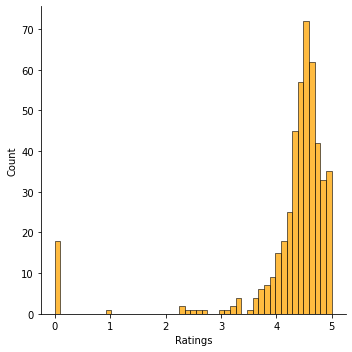

<Figure size 504x504 with 0 Axes>

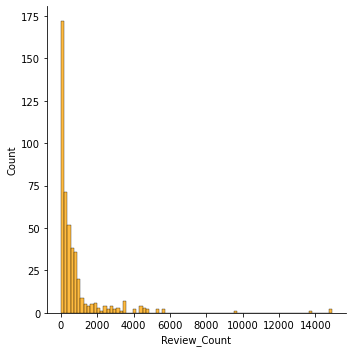

<Figure size 504x504 with 0 Axes>

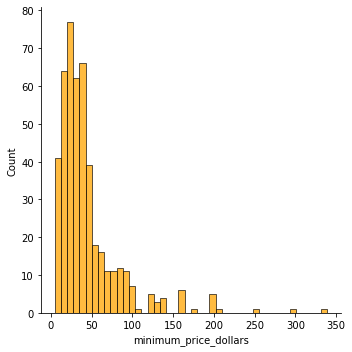

<Figure size 504x504 with 0 Axes>

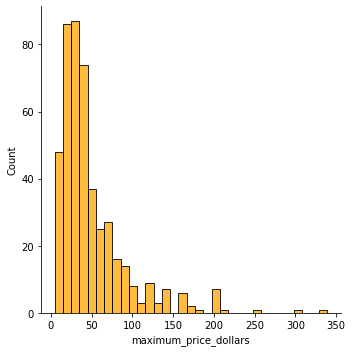

In [19]:
# Numerical data
numerical_data=['Ratings','Review_Count', 'minimum_price_dollars', 'maximum_price_dollars']
for fields in numerical_data:
    plt.figure(figsize=(7,7))
    sns.displot(skincare_cleandata[fields],color='orange')
    plt.show()

***Observations***:

   * ALl the numerical variable are mostly normally distibuted but are heavily skewed towards one side.
   * Most products in our data are rated closer to 4 and 5.
   * Most products has the number of reviews less than 2000.
   * Most products minimum price ranges below 50 $
   * Most products maximum price ranges below 50 $
    

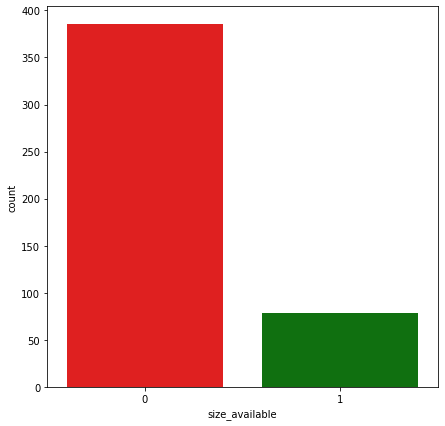

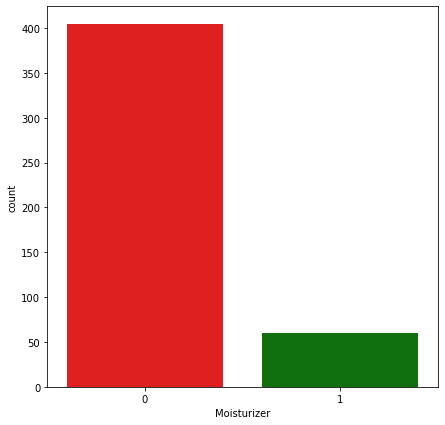

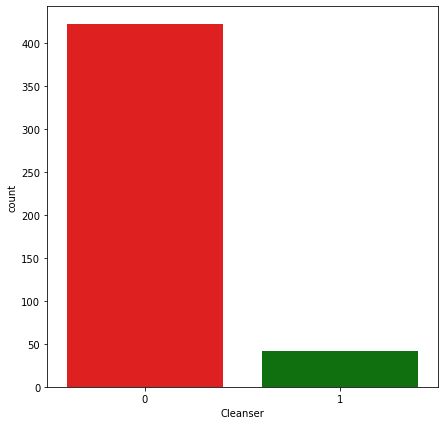

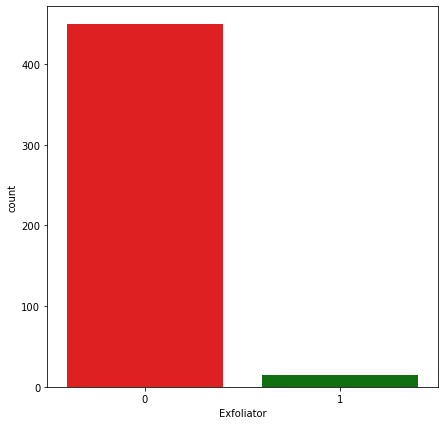

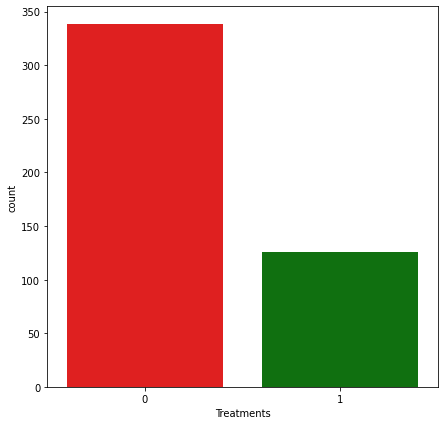

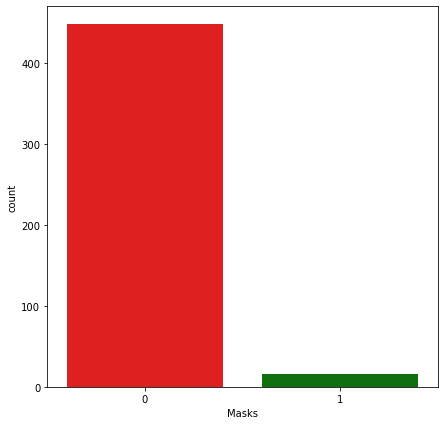

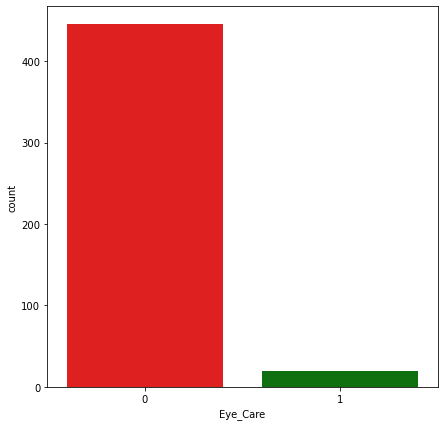

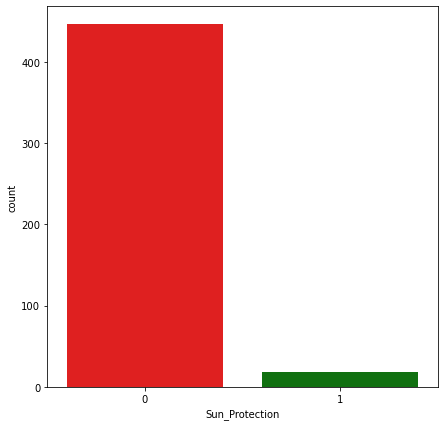

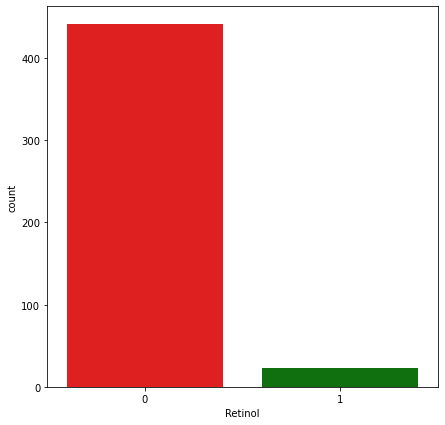

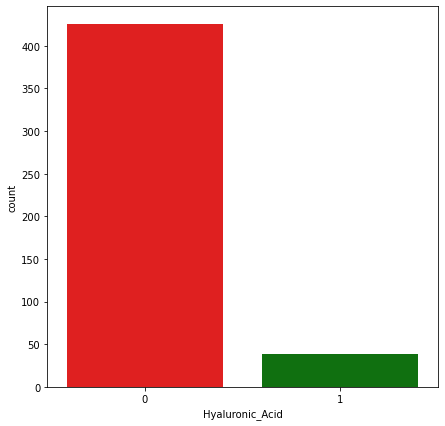

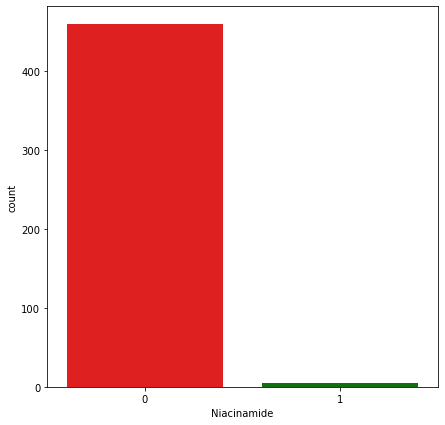

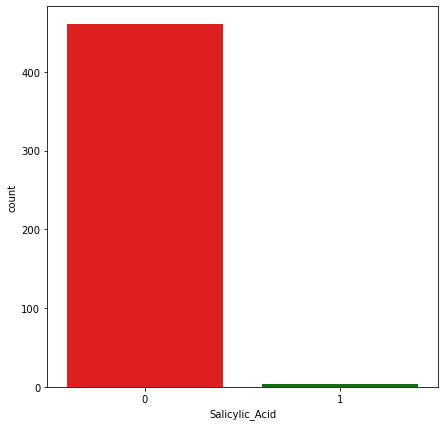

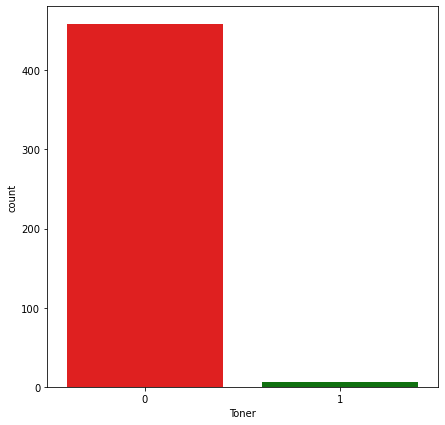

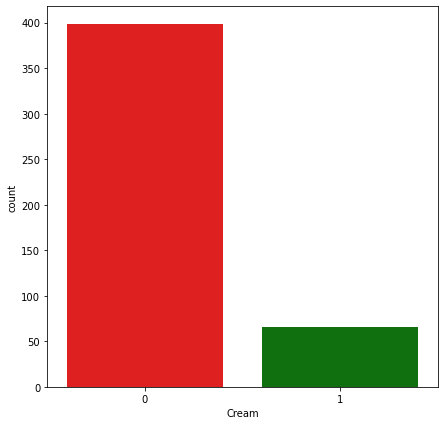

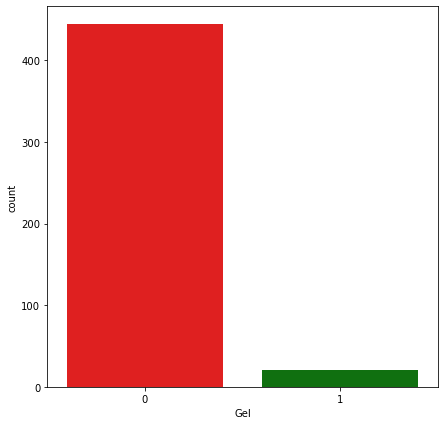

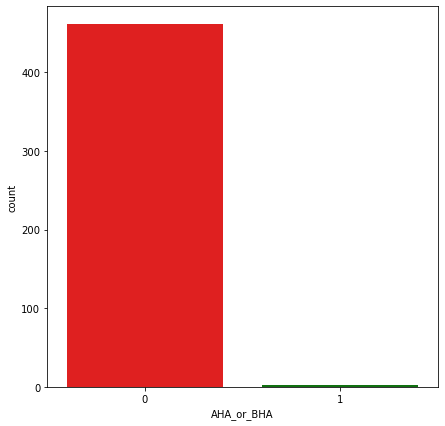

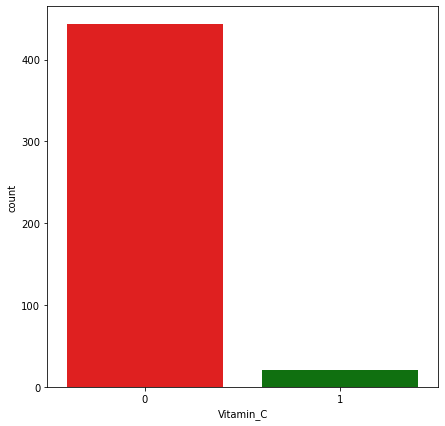

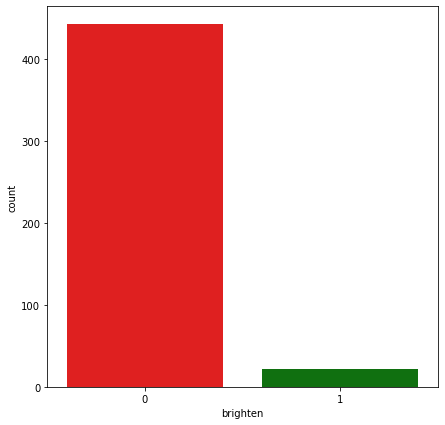

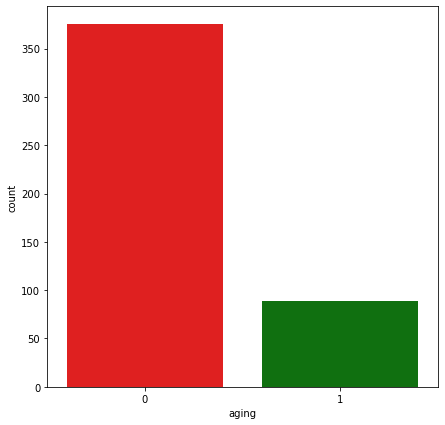

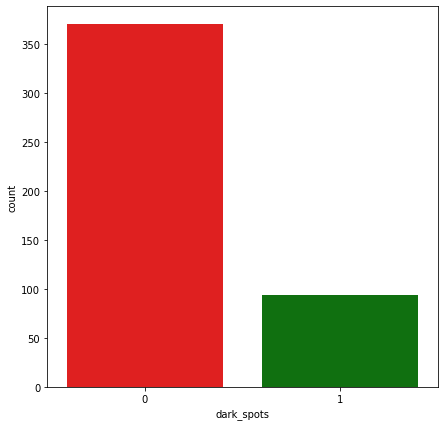

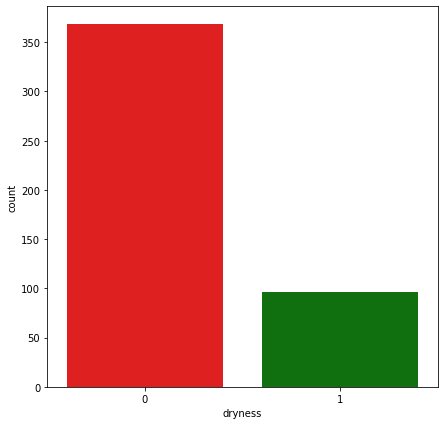

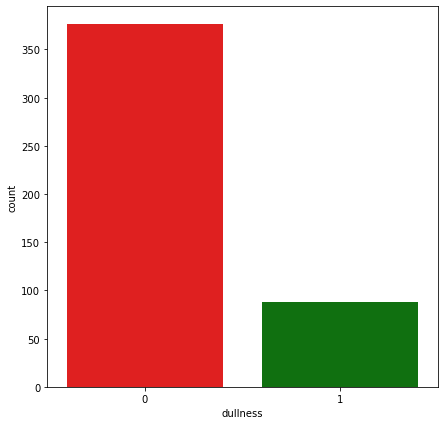

In [20]:
categorical=['size_available',
       'Moisturizer', 'Cleanser', 'Exfoliator', 'Treatments', 'Masks',
       'Eye_Care', 'Sun_Protection', 'Retinol', 'Hyaluronic_Acid',
       'Niacinamide', 'Salicylic_Acid', 'Toner', 'Cream', 'Gel', 'AHA_or_BHA',
       'Vitamin_C', 'brighten', 'aging', 'dark_spots', 'dryness', 'dullness']
for field in categorical:
    plt.figure(figsize=(7,7))
    sns.countplot(skincare_cleandata[field],palette=['red','green'])
    plt.show()

### Bivariate Analysis:

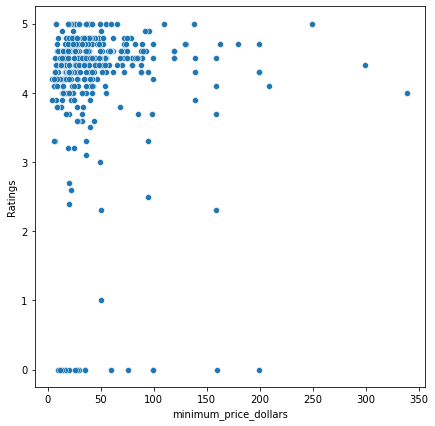

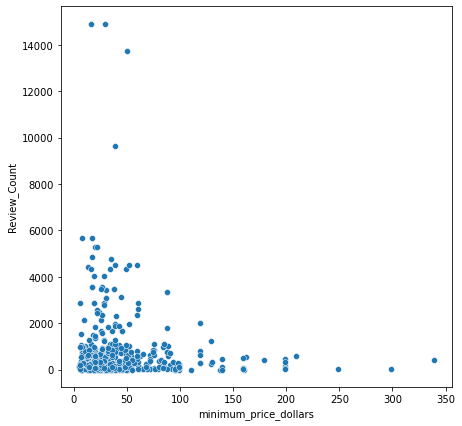

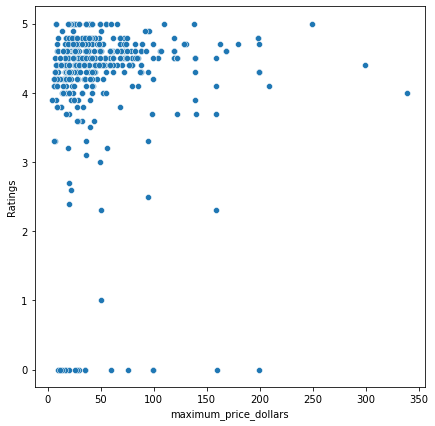

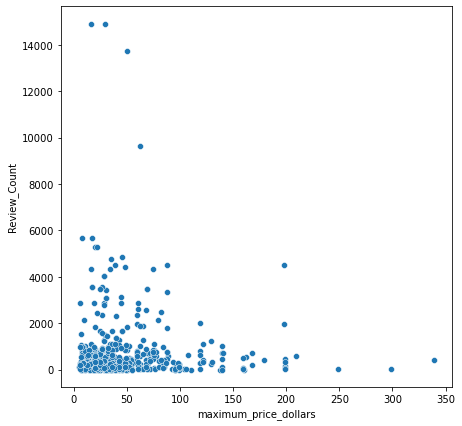

In [21]:
# Numerical vs Numercial data analysis
x=['minimum_price_dollars','maximum_price_dollars']
y=['Ratings','Review_Count' ]
for i in x:
    for j in y:
        plt.figure(figsize=(7,7))
        sns.scatterplot(x=i,y=j,data=skincare_cleandata)
        plt.show()

There are no visible patterns between all 4 numerical fields.

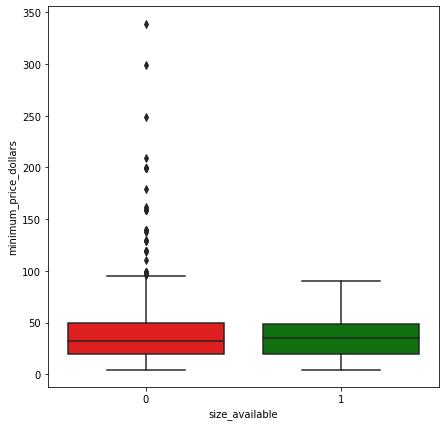

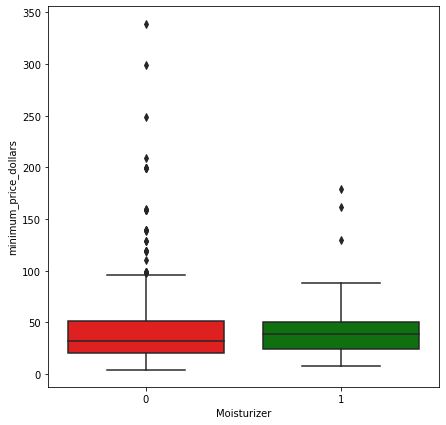

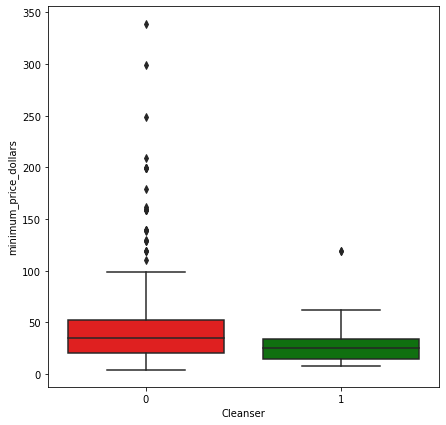

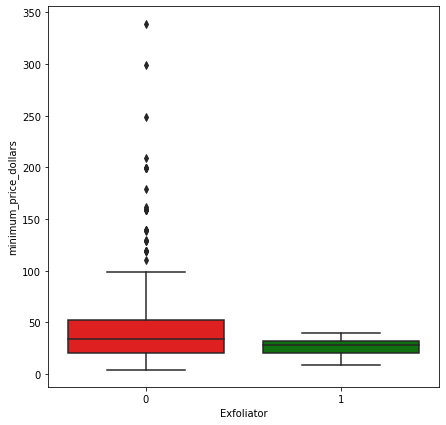

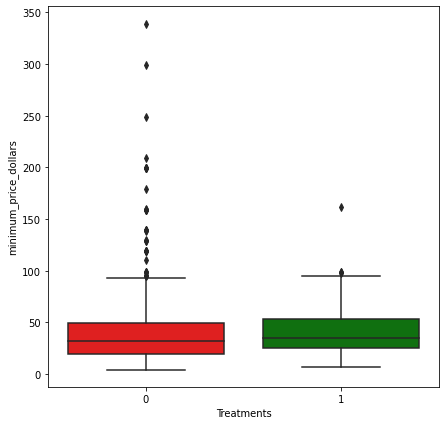

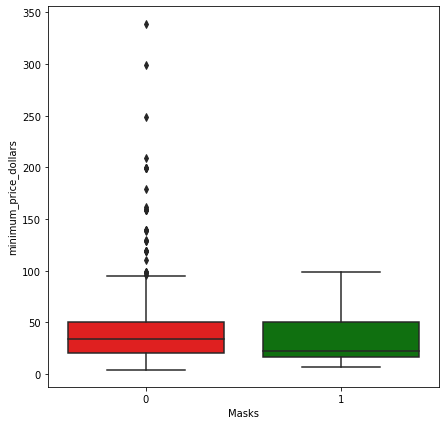

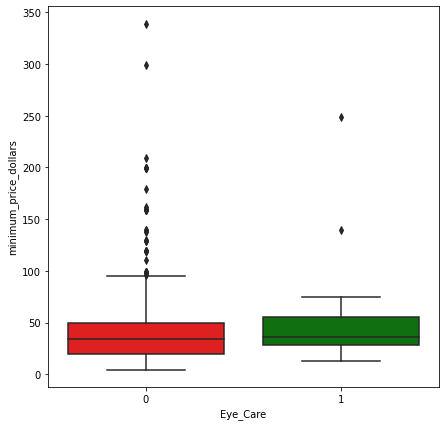

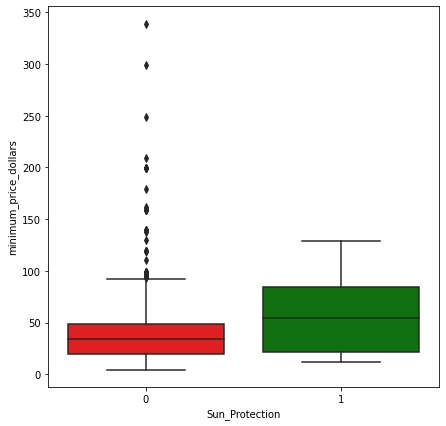

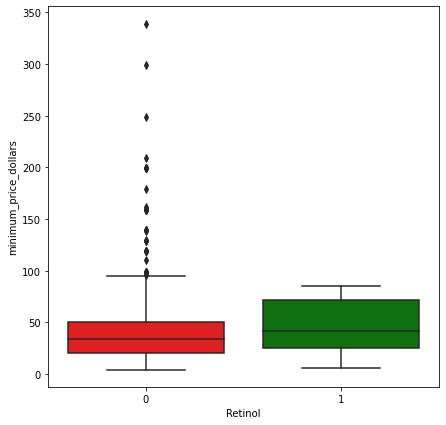

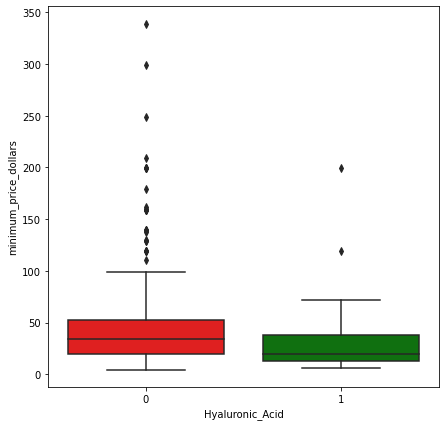

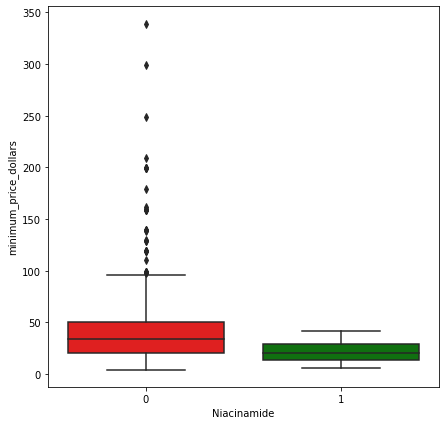

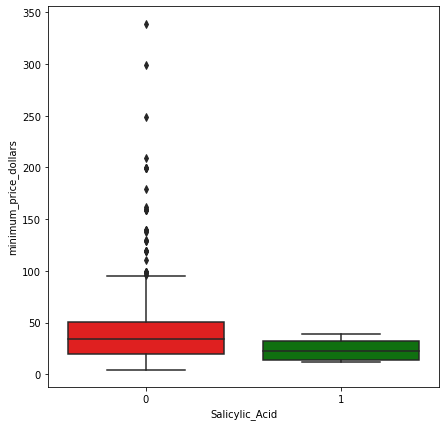

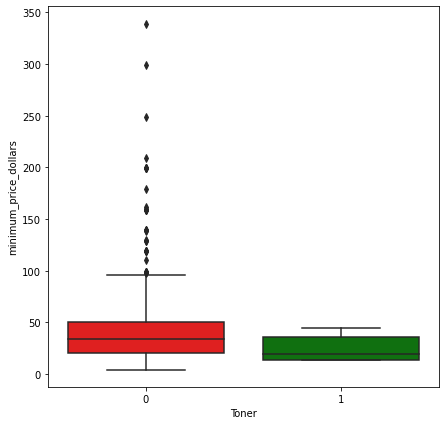

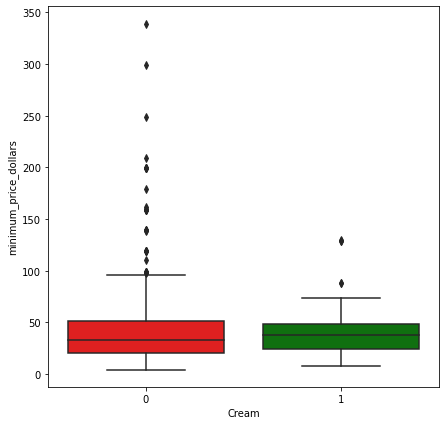

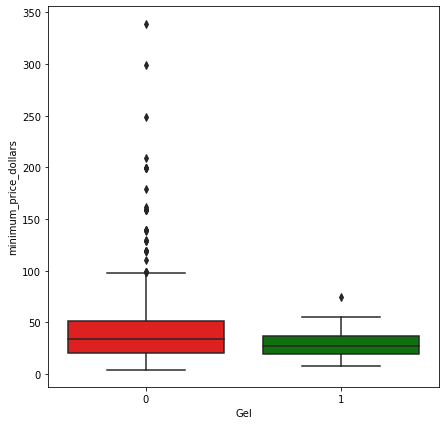

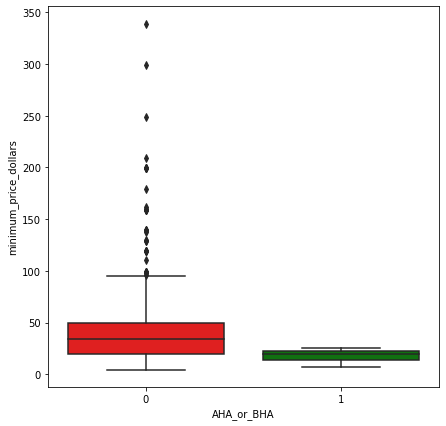

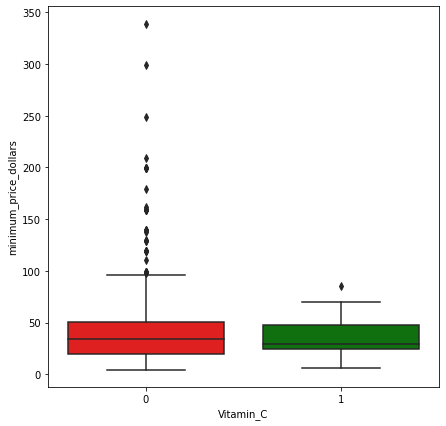

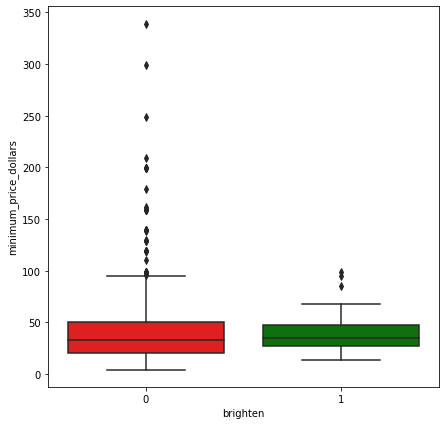

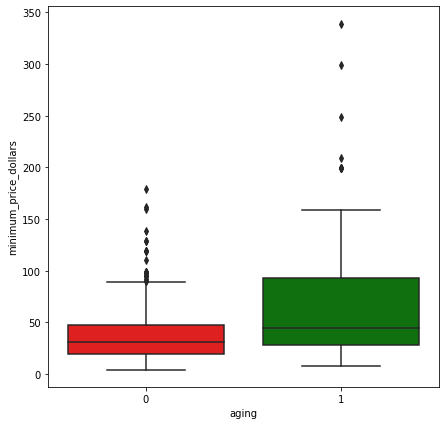

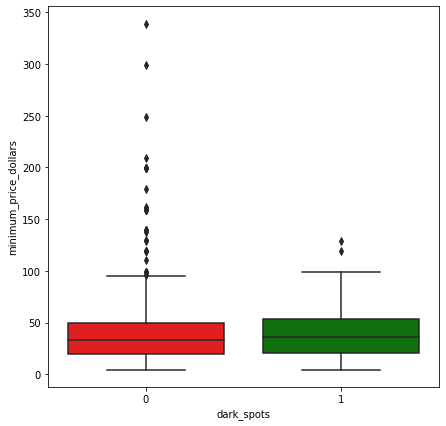

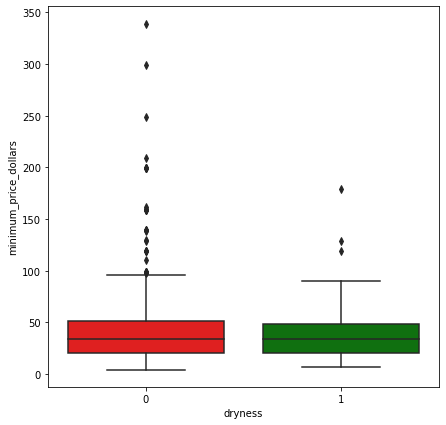

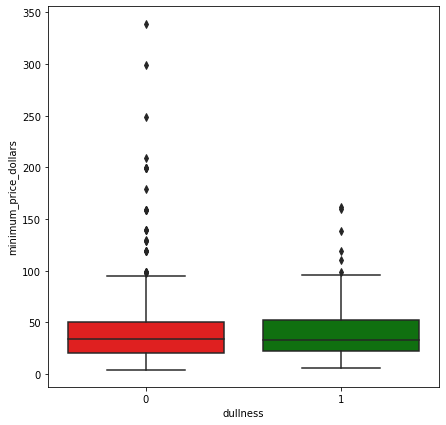

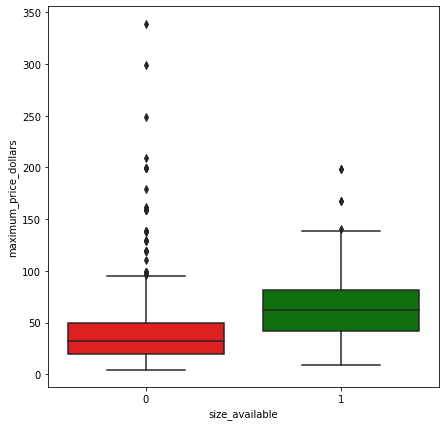

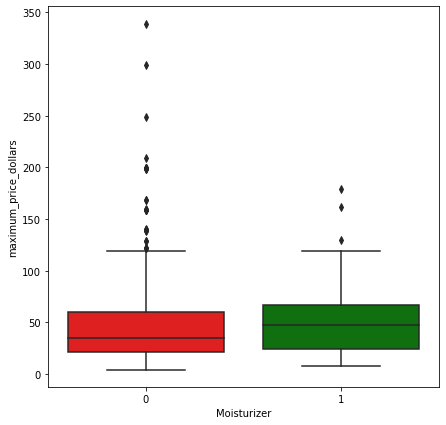

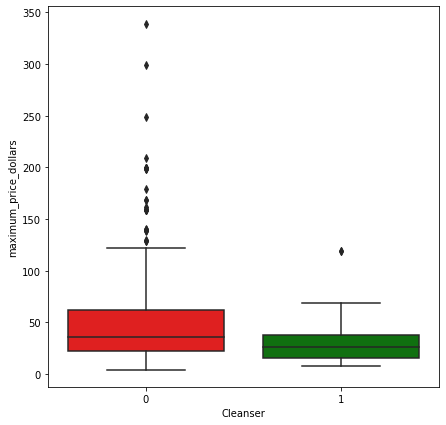

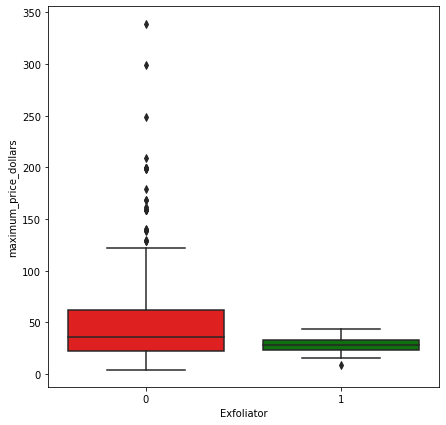

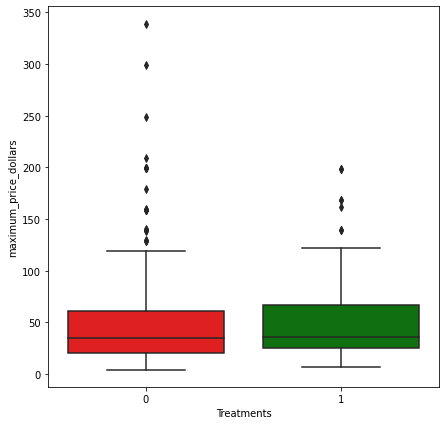

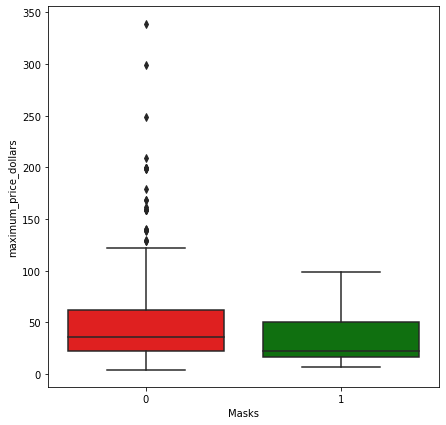

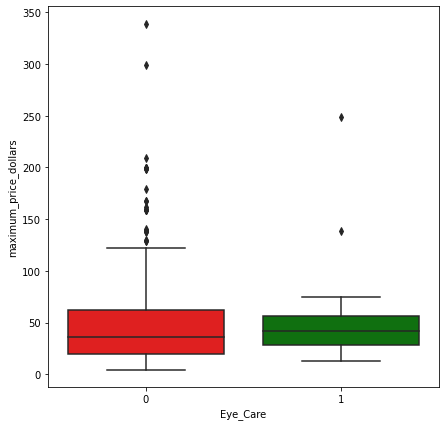

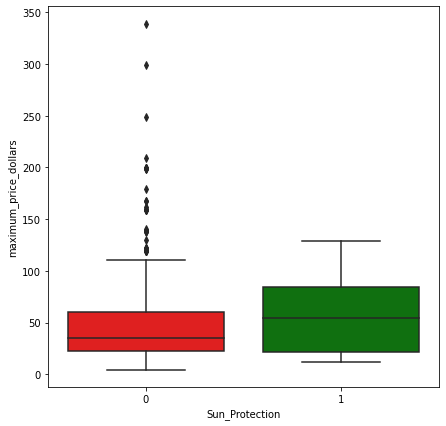

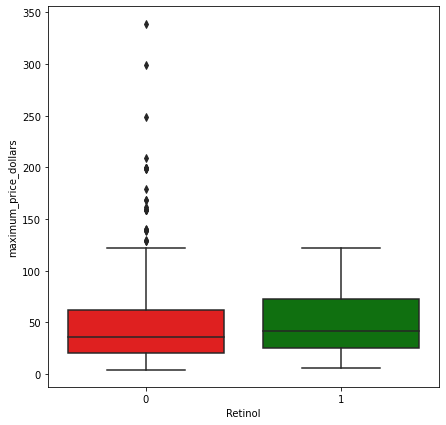

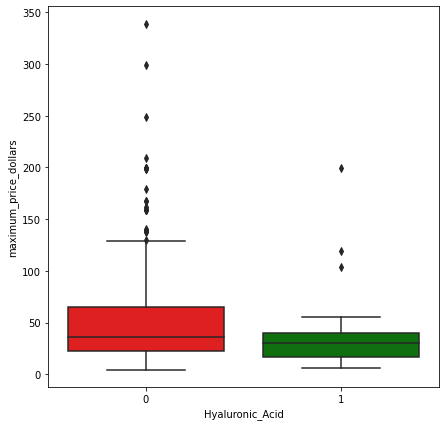

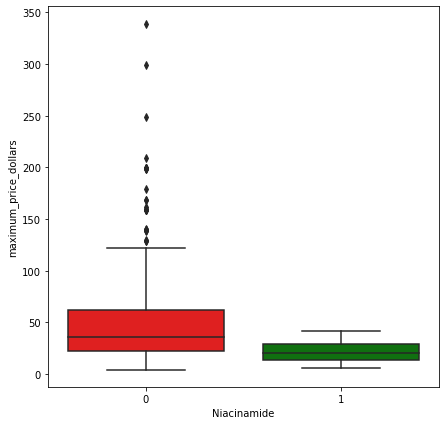

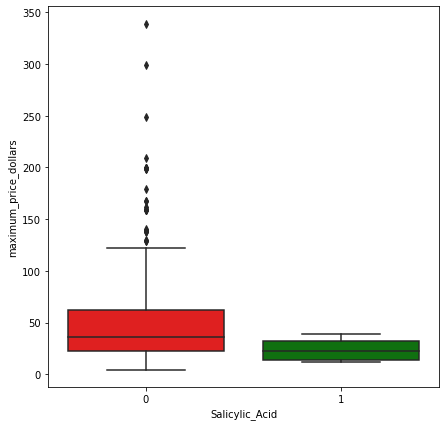

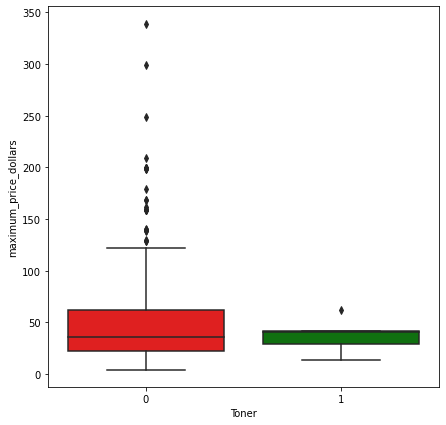

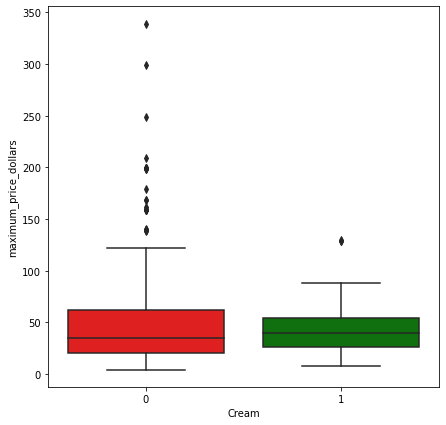

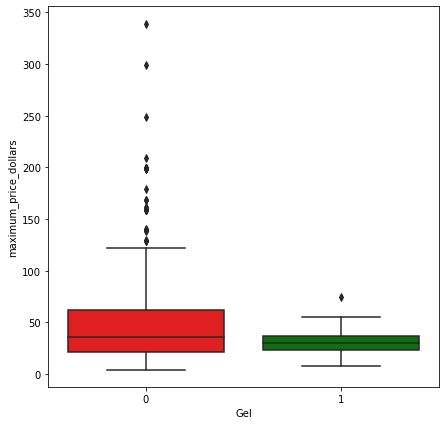

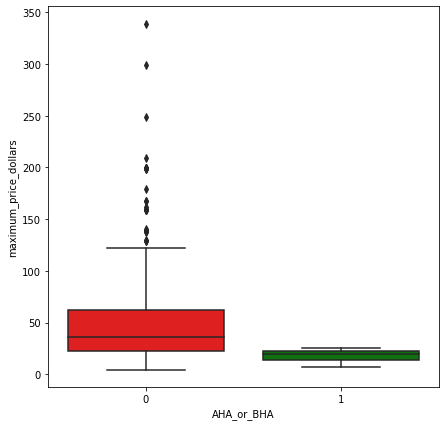

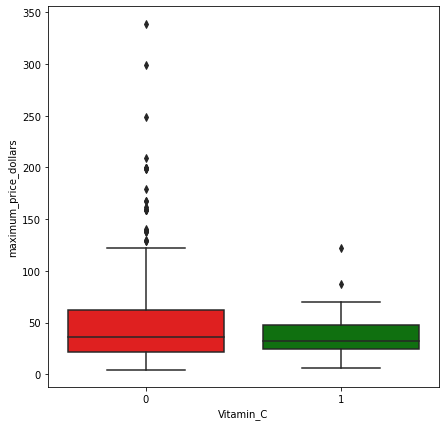

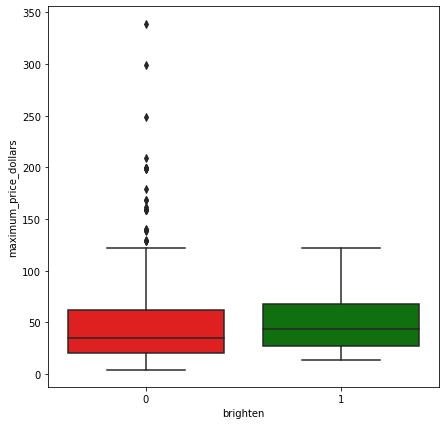

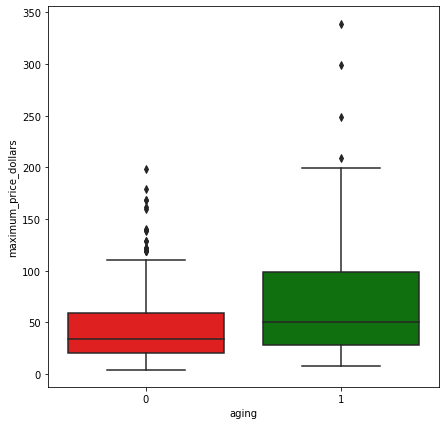

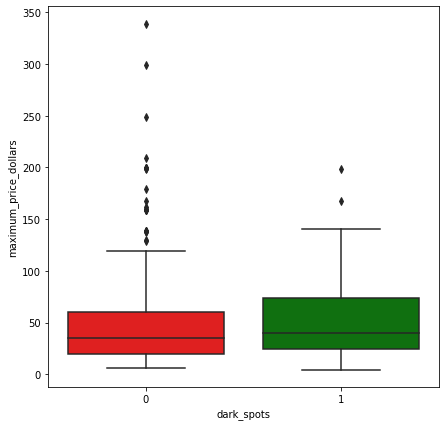

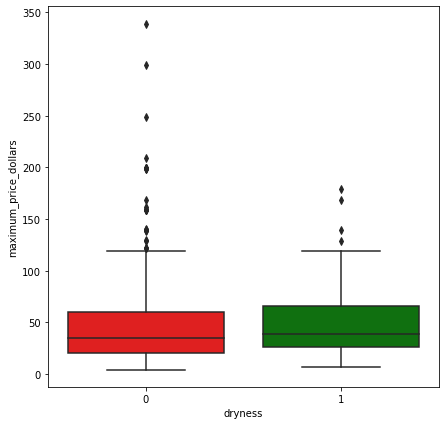

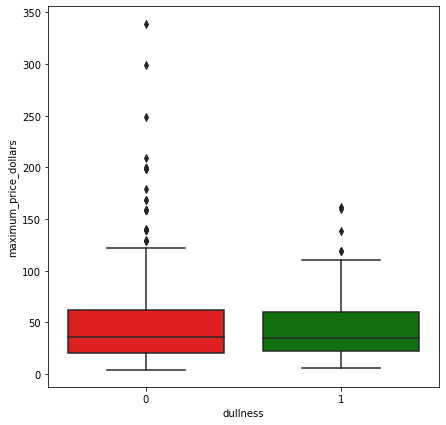

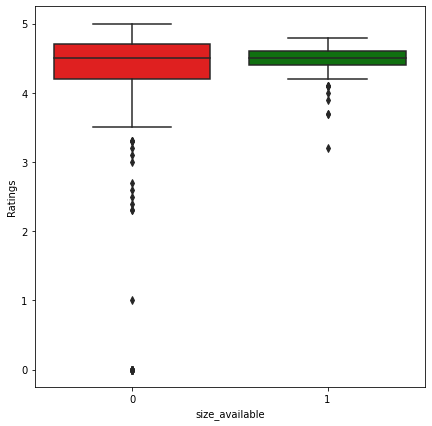

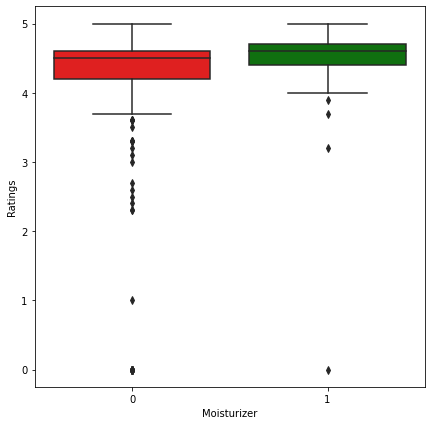

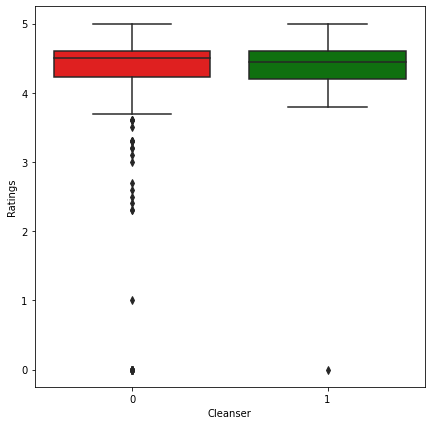

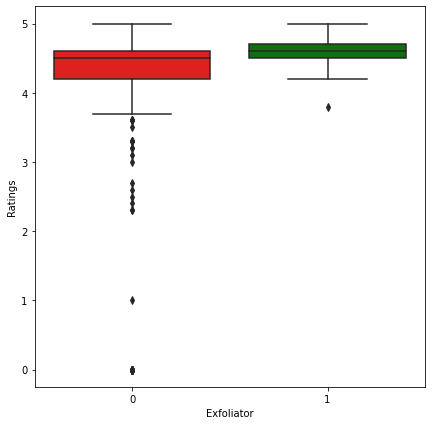

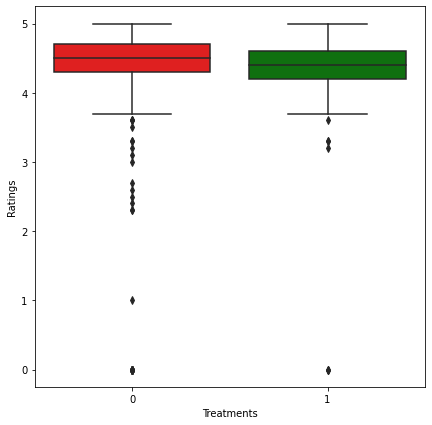

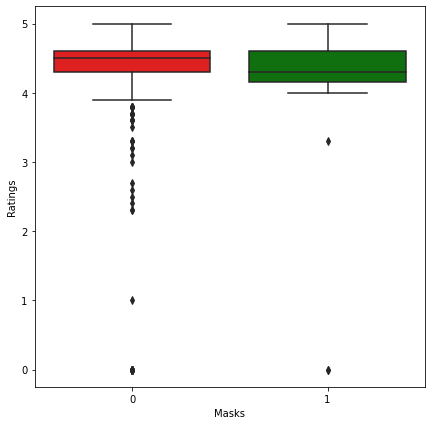

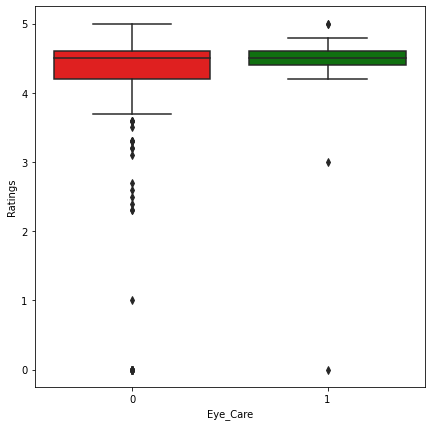

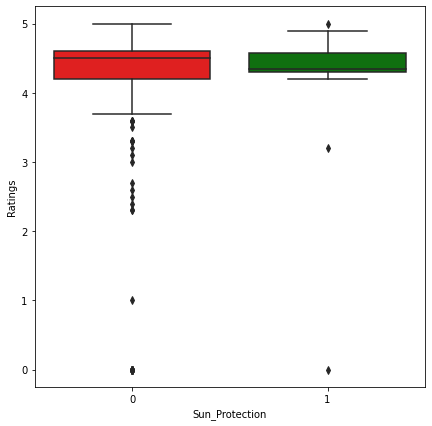

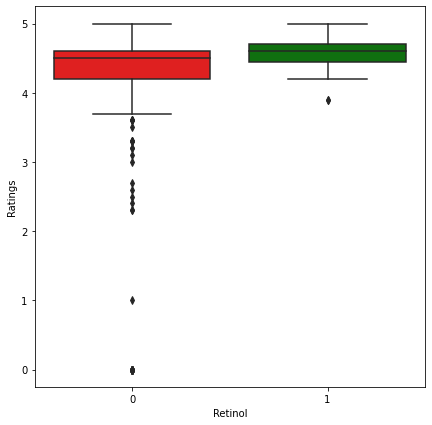

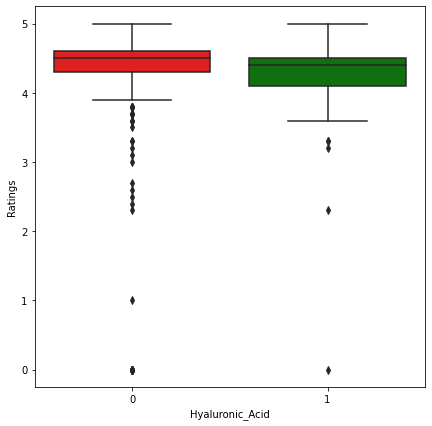

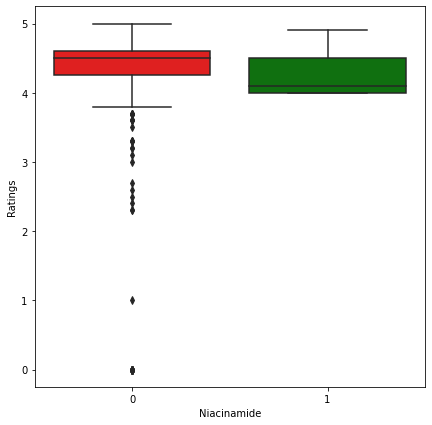

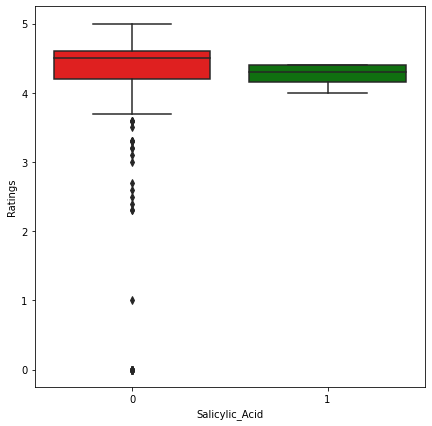

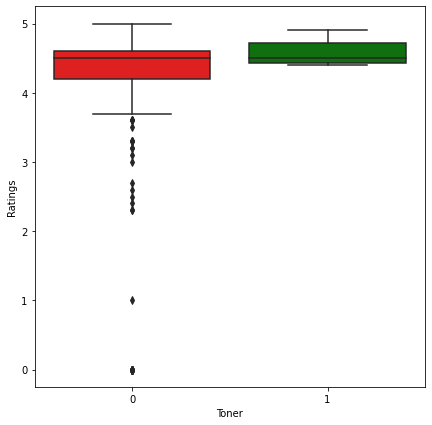

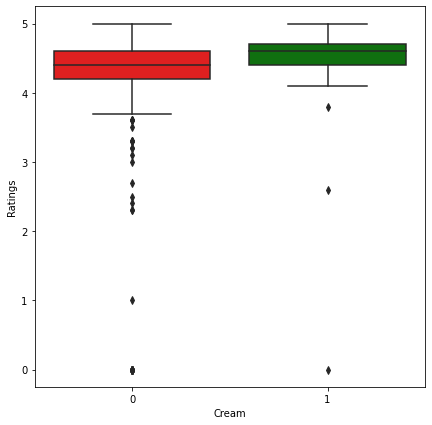

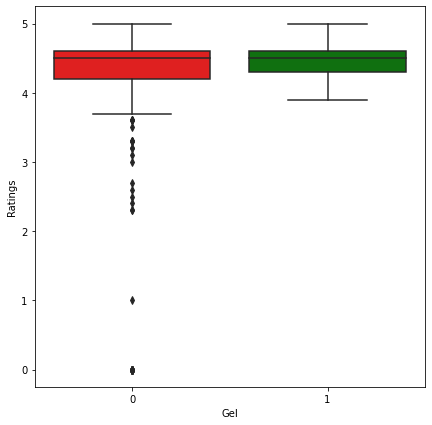

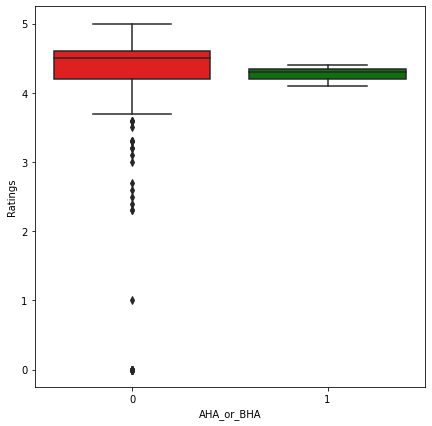

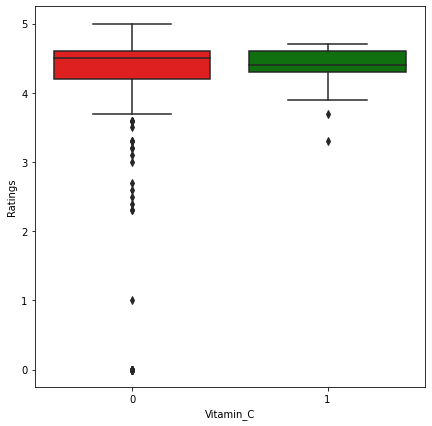

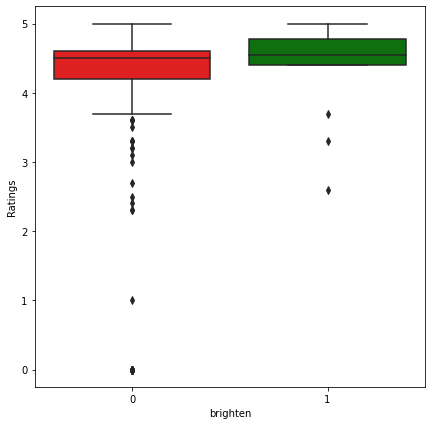

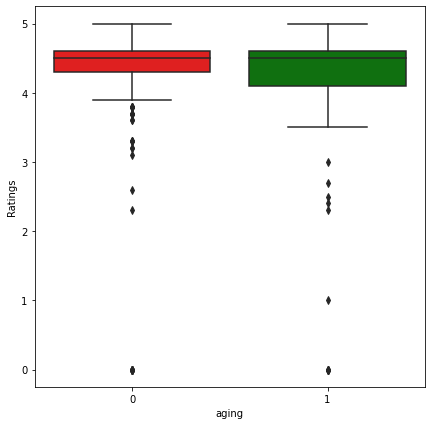

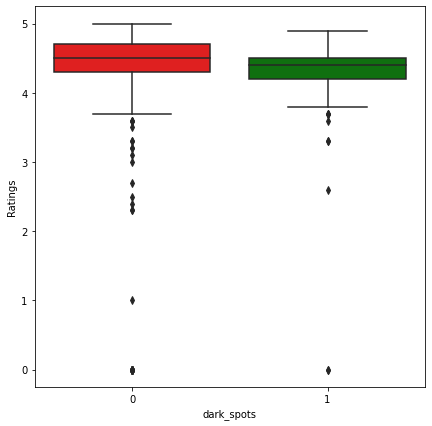

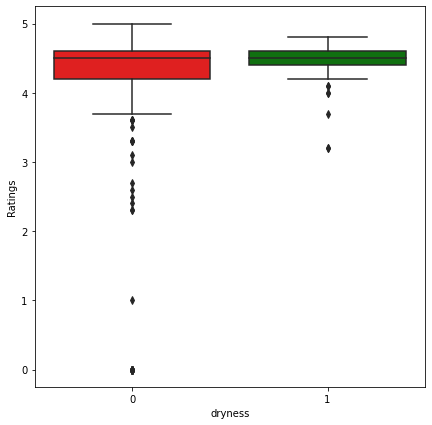

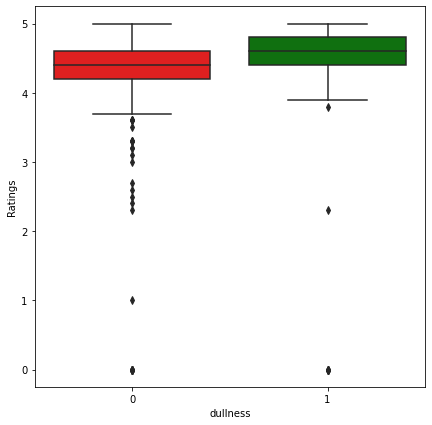

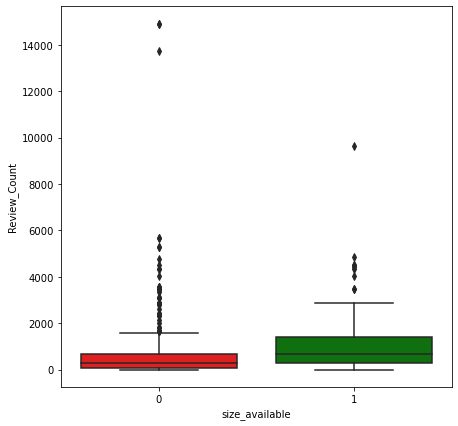

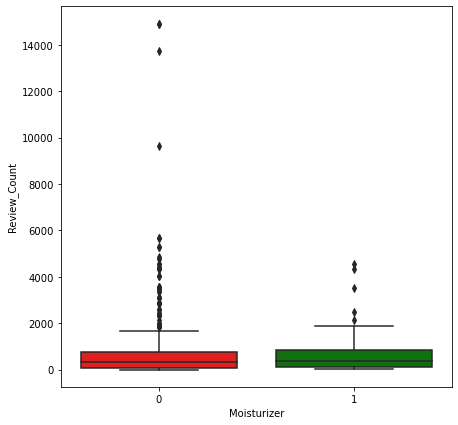

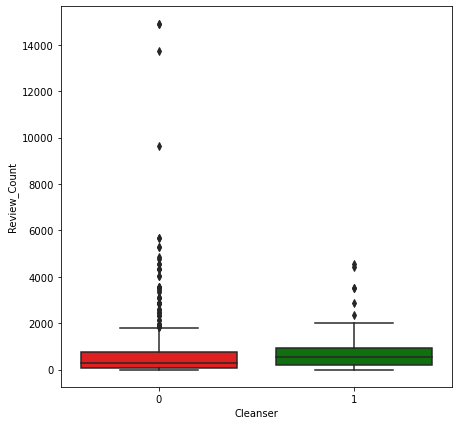

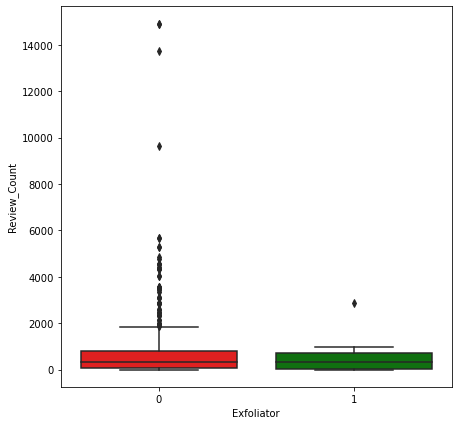

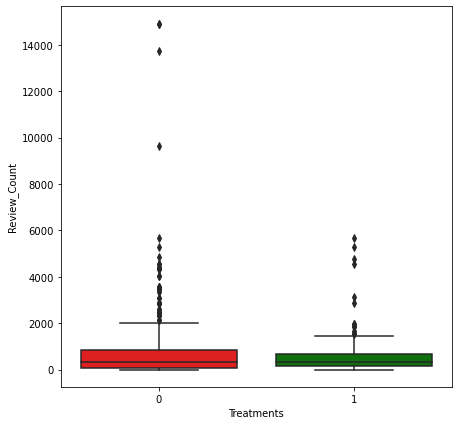

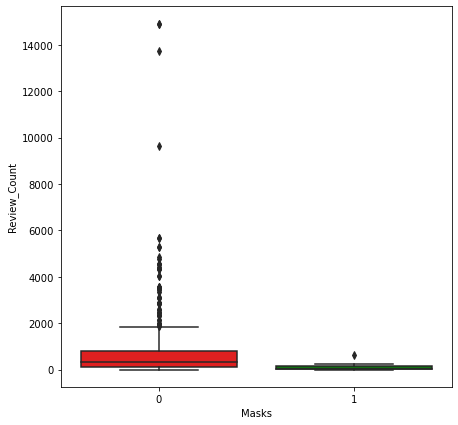

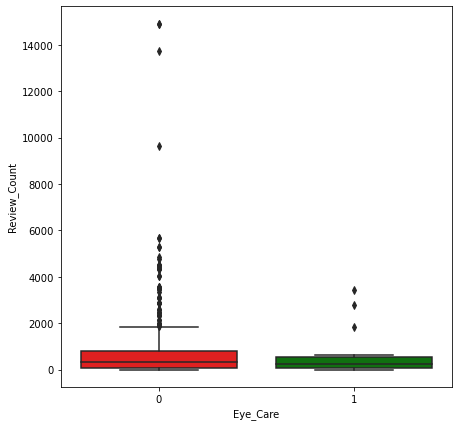

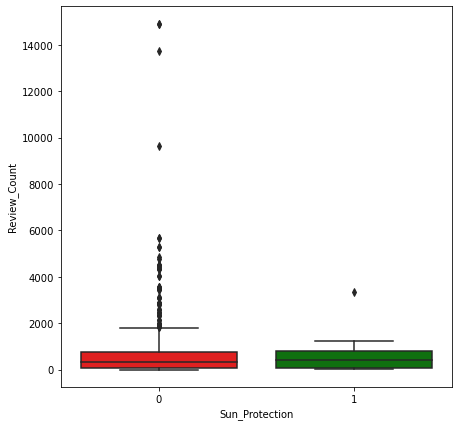

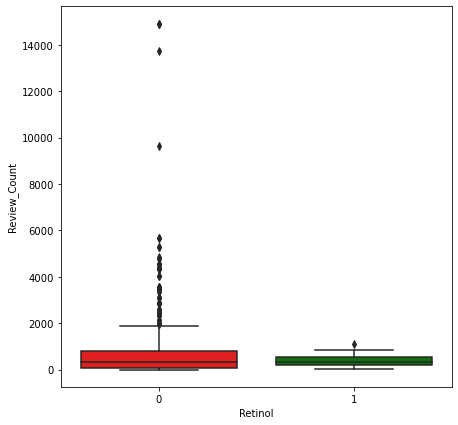

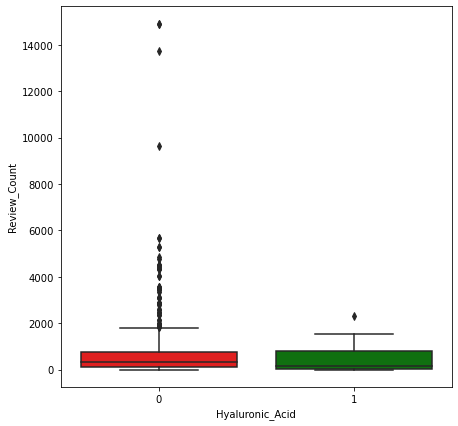

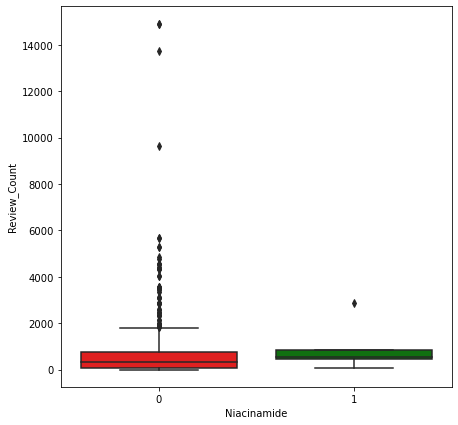

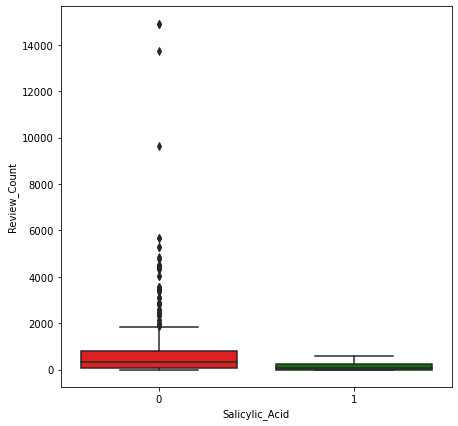

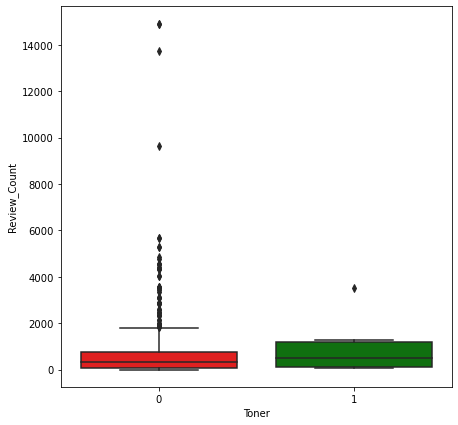

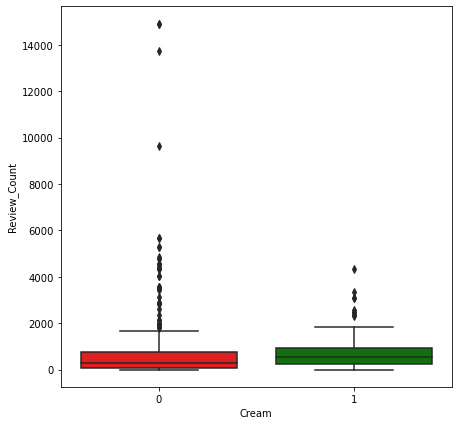

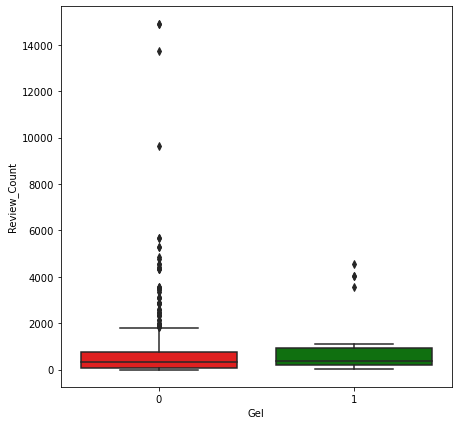

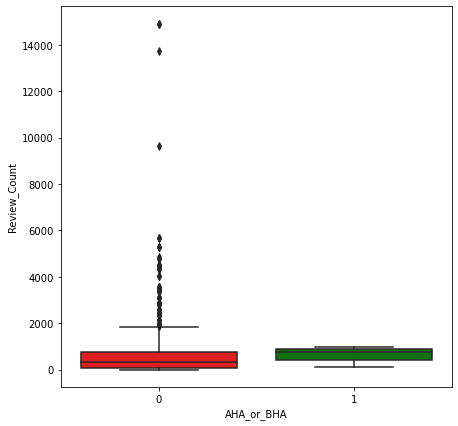

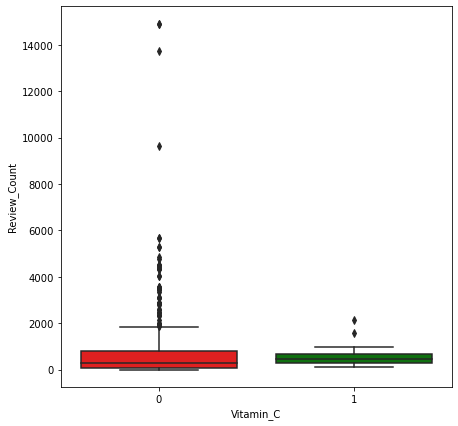

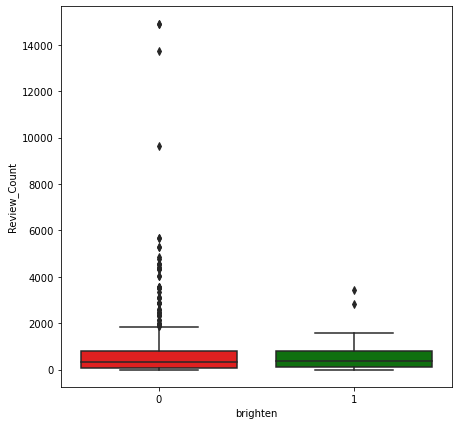

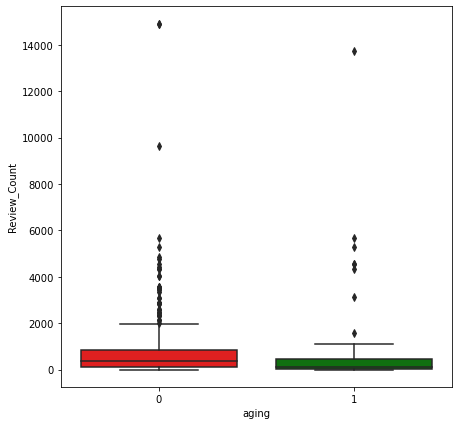

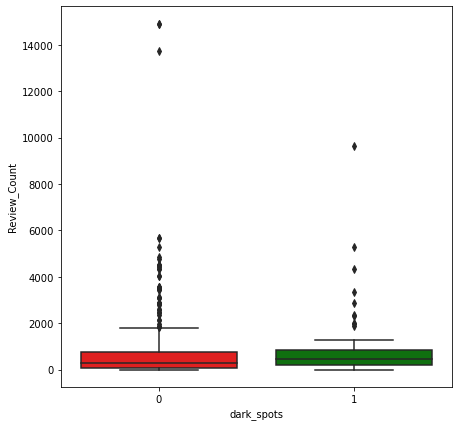

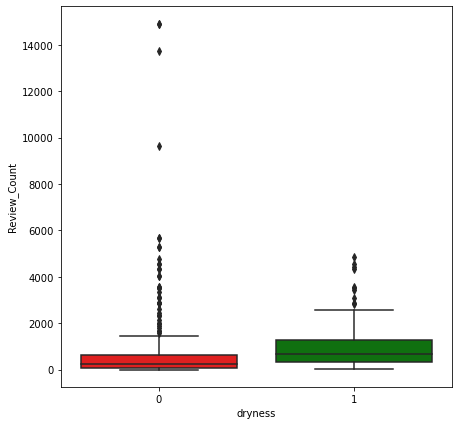

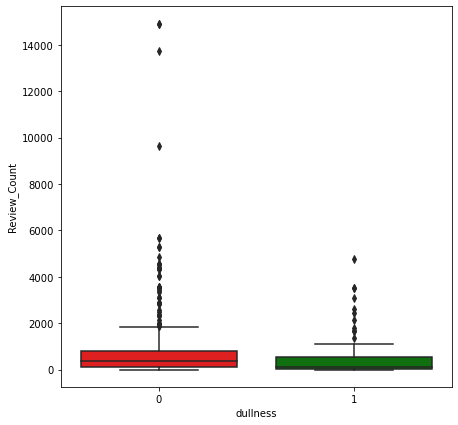

In [22]:
x=['minimum_price_dollars','maximum_price_dollars','Ratings','Review_Count']
y=['size_available',
       'Moisturizer', 'Cleanser', 'Exfoliator', 'Treatments', 'Masks',
       'Eye_Care', 'Sun_Protection', 'Retinol', 'Hyaluronic_Acid',
       'Niacinamide', 'Salicylic_Acid', 'Toner', 'Cream', 'Gel', 'AHA_or_BHA',
       'Vitamin_C', 'brighten', 'aging', 'dark_spots', 'dryness', 'dullness']
for i in x:
    for j in y:
        plt.figure(figsize=(7,7))
        sns.boxplot(x=j,y=i,data=skincare_cleandata,palette=['red','green'])
        plt.show()

###### Some of the insights are :
* Mosituriser, treatments has the median value of price higher than other kind of products
* The products that are used to treat aging are highly prized than other products.
* products that are brighten and are of mosituriser and treatment contains more review counts rather than other products.
* products used to treat dullness and cleaners are high rated.
* while products with vitamin c are low rated items.

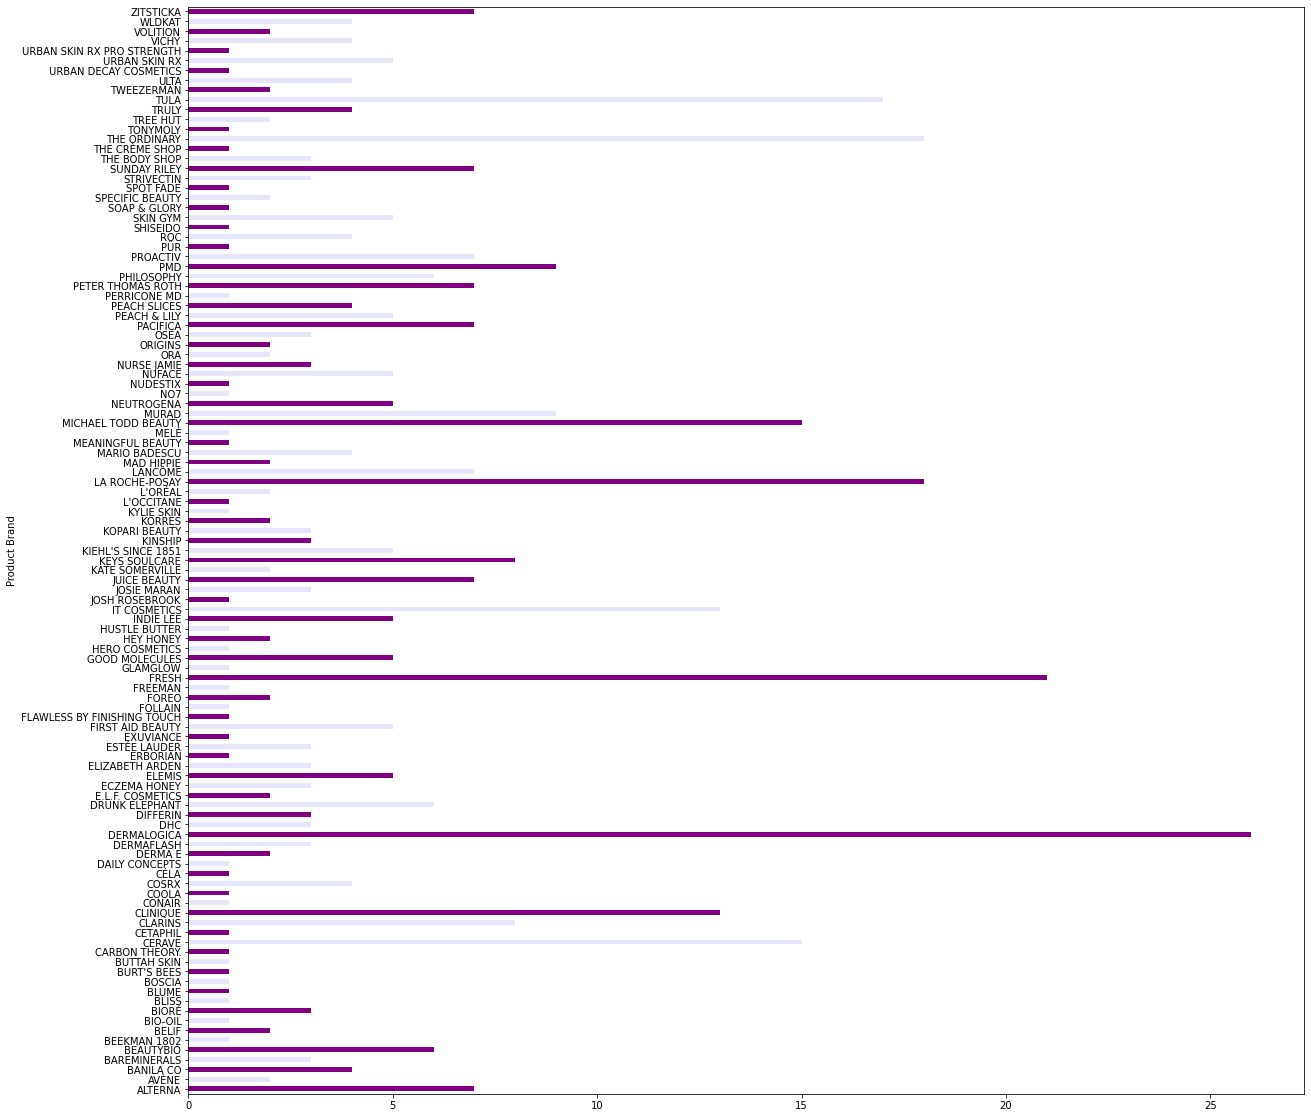

In [23]:
 plt.figure(figsize=(20,20))
skincare_cleandata.groupby('Product Brand')['Product Brand'].count().plot.barh(color=['purple','lavender'])
plt.show()

* More number of products are from brand `Dermalogia`.
* 2 nd highest number of products are from `cerave` and `IT cosmetics`.

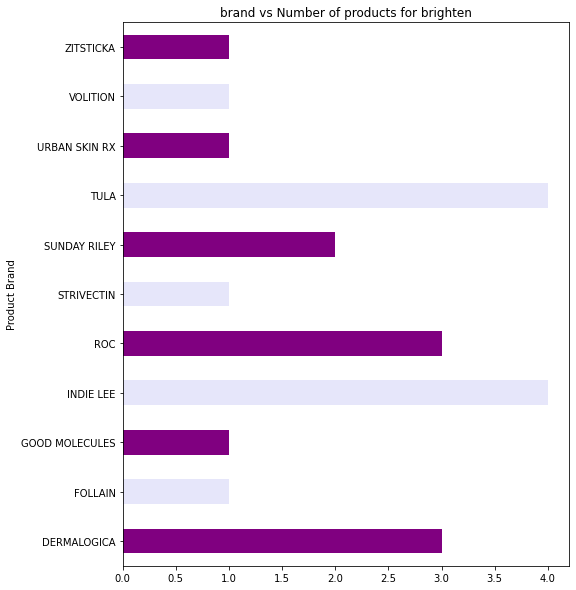

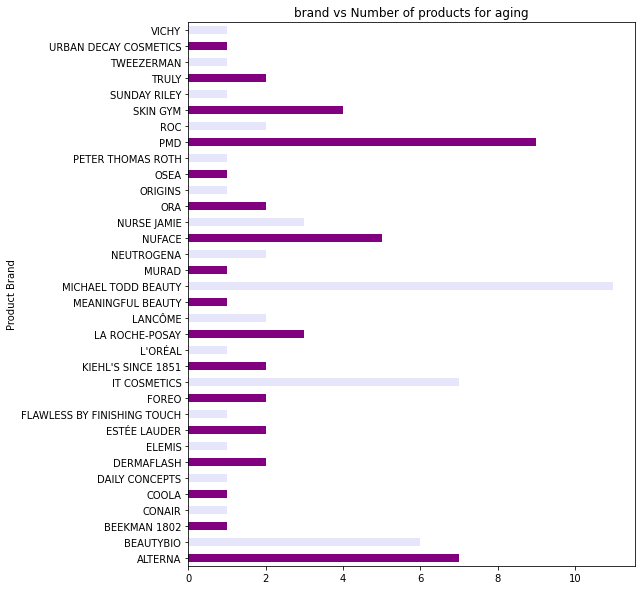

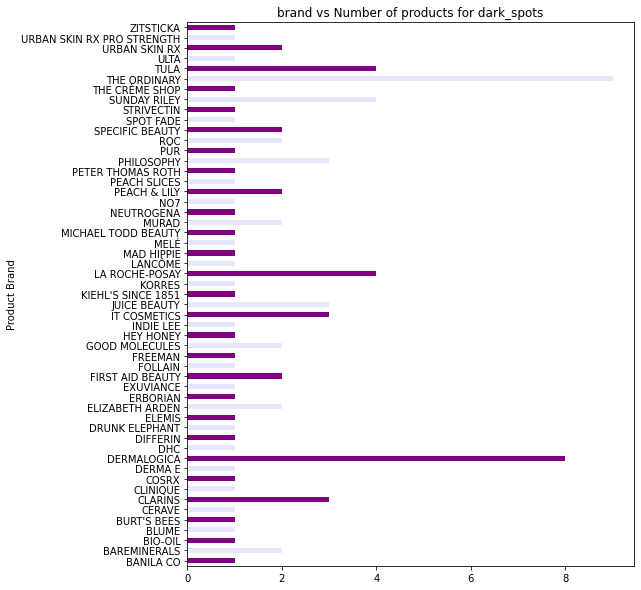

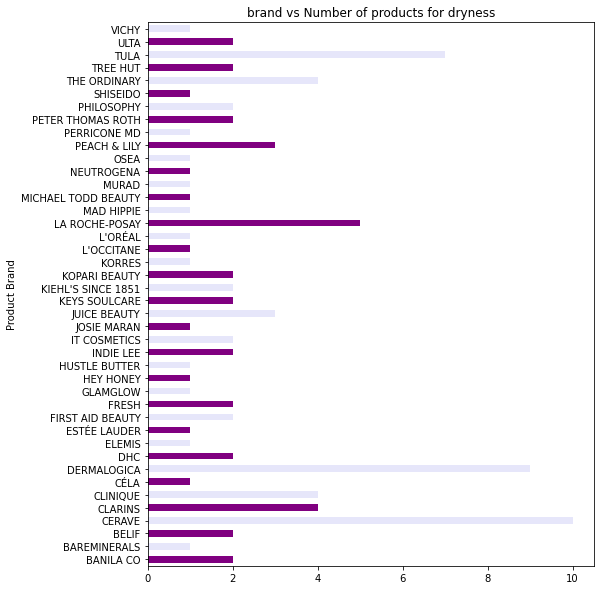

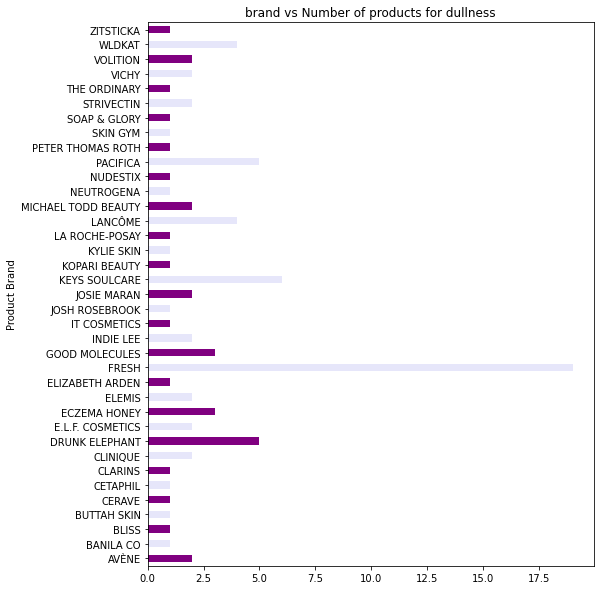

In [24]:
# let us go ahead and visualize the brand and number of products they offer for each concern.
for concern in [ 'brighten', 'aging', 'dark_spots', 'dryness', 'dullness']:
    plt.figure(figsize=(8,10))
    brandwise_solution=skincare_cleandata.groupby('Product Brand')[concern].sum()
    brandwise_solution[brandwise_solution>0].plot.barh(color=['purple','lavender'])
    plt.title("brand vs Number of products for {0}".format(concern))
    plt.show()

### Top brands interms of number of products for skin concern
* INDILEE offers more products for brigtening
* Michael Todd Beauty for aging
* The ordinary for dark spots
* Cerave for dryness and Fresh for dullness

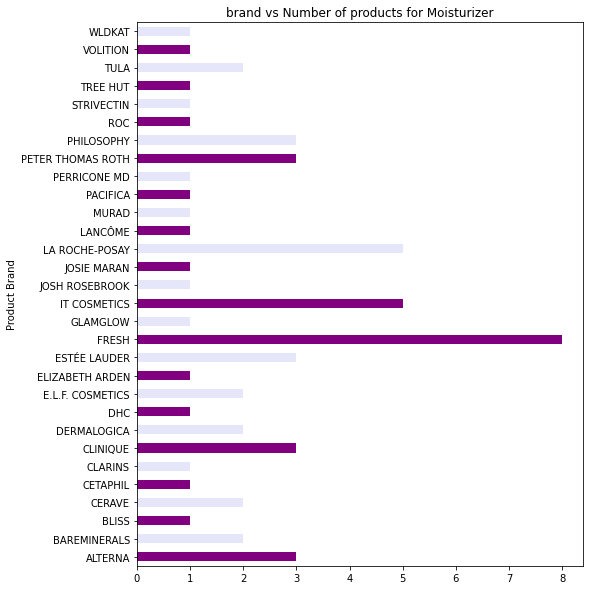

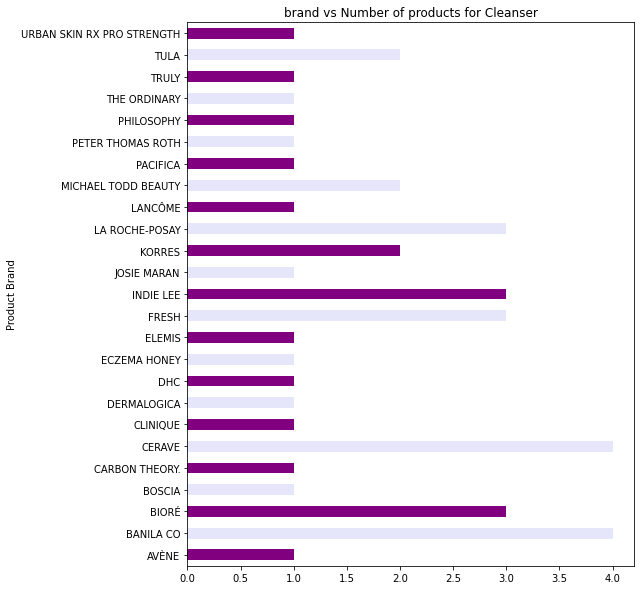

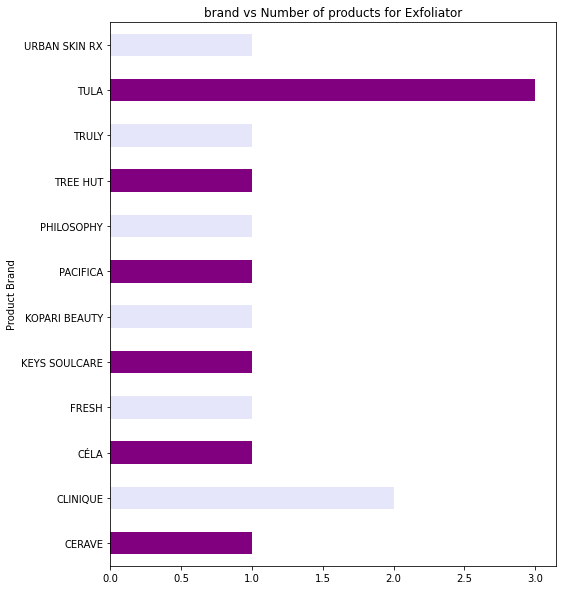

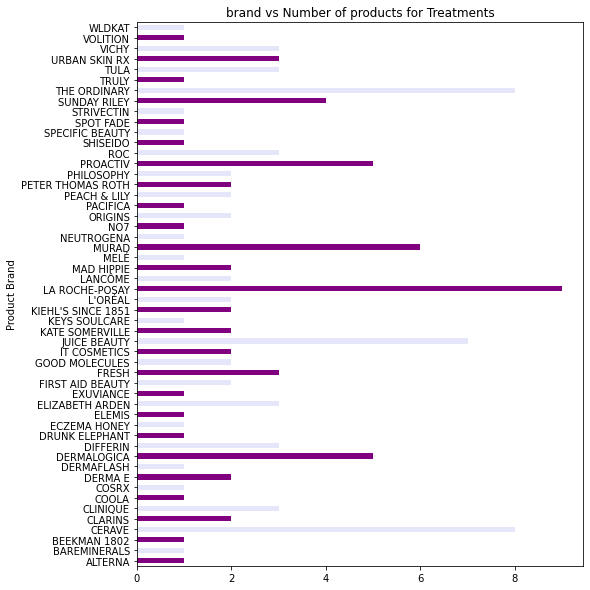

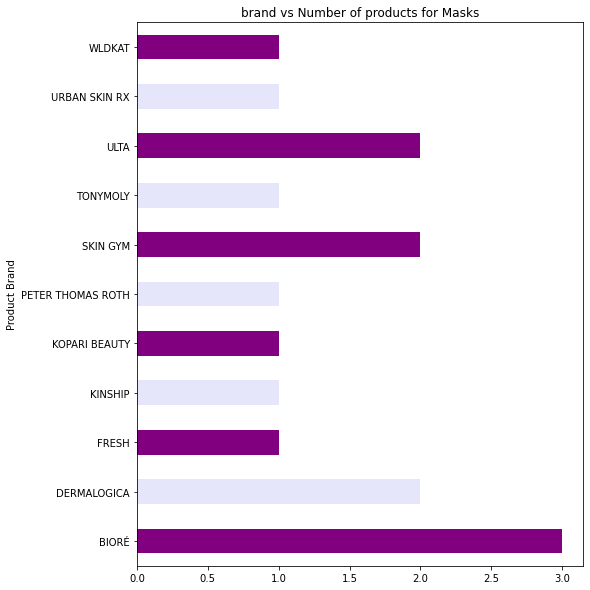

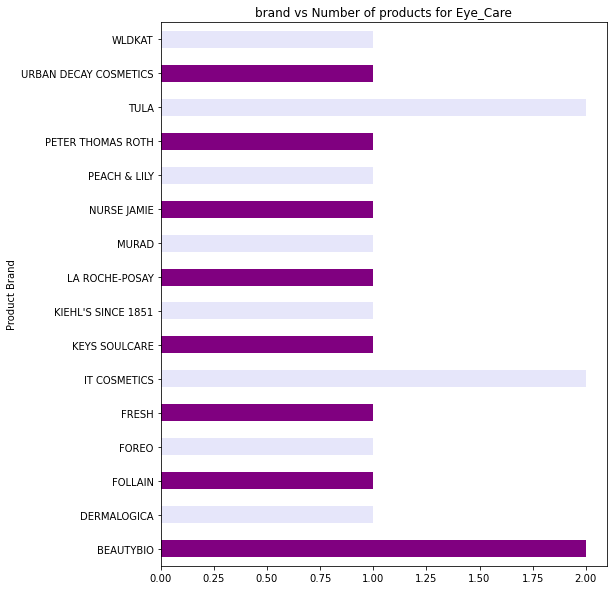

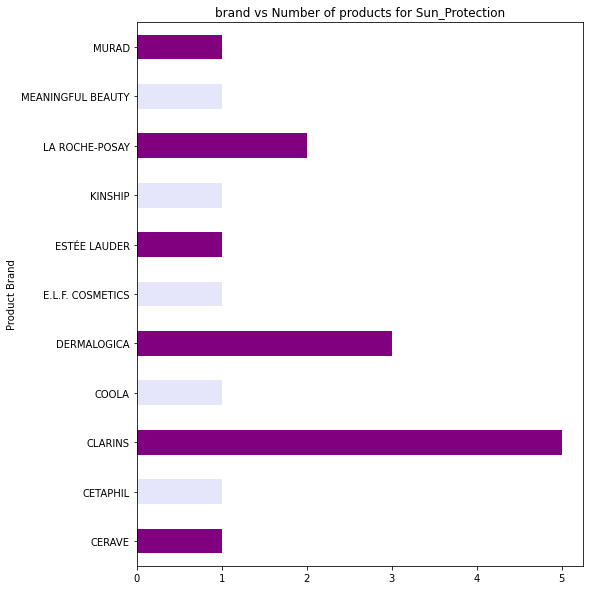

In [25]:
products=['Moisturizer', 'Cleanser', 'Exfoliator', 'Treatments', 'Masks',
       'Eye_Care', 'Sun_Protection']
for p in products:
    plt.figure(figsize=(8,10))
    brandwise_care=skincare_cleandata.groupby('Product Brand')[p].sum()
    brandwise_care[brandwise_care>0].plot.barh(color=['purple','lavender'])
    plt.title("brand vs Number of products for {0}".format(p))
    plt.show()

### Top brands interms of number of products /according to product type

* Fresh offers more products that are moisturiser.
* Tula offers more number of Exfoliator products
* The ordinary has more treatment products
* Cerave offers more number of cleanser products
* Biore brand offers more Mask products.

### Multivariate Analysis

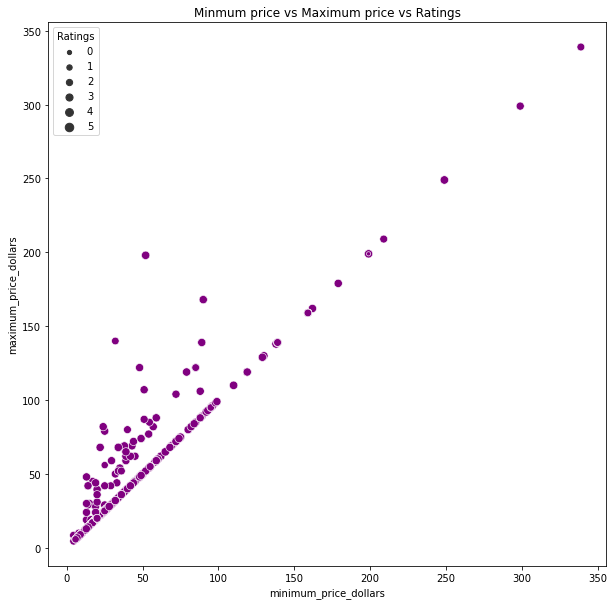

In [26]:
# Minimum price vs maximum price vs ratings
plt.figure(figsize=(10,10))
sns.scatterplot(x=skincare_cleandata['minimum_price_dollars'],y=skincare_cleandata['maximum_price_dollars'],size=skincare_cleandata['Ratings'],color='purple')
plt.title('Minmum price vs Maximum price vs Ratings')
plt.show()

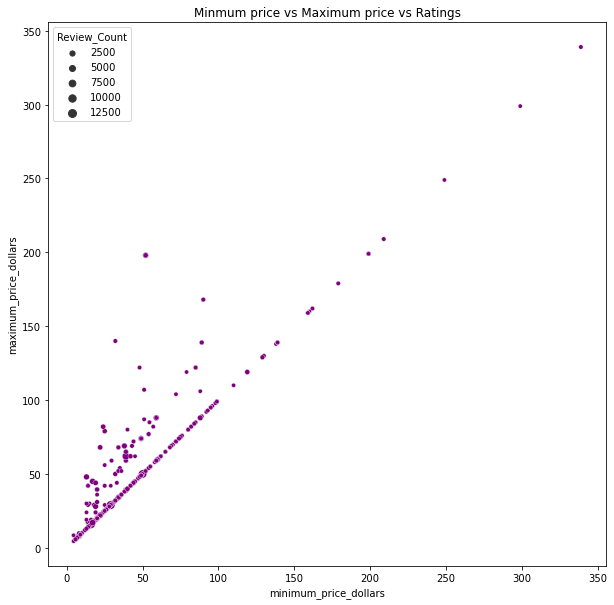

In [27]:
# Minimum price vs maximum price vs review count
plt.figure(figsize=(10,10))
sns.scatterplot(x=skincare_cleandata['minimum_price_dollars'],y=skincare_cleandata['maximum_price_dollars'],size=skincare_cleandata['Review_Count'],color='purple')
plt.title('Minmum price vs Maximum price vs Ratings')
plt.show()

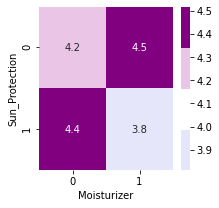

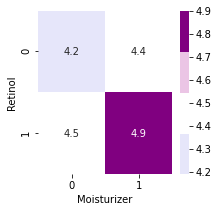

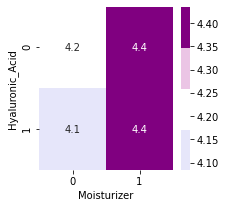

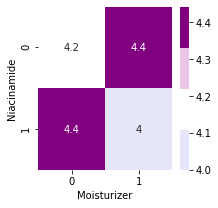

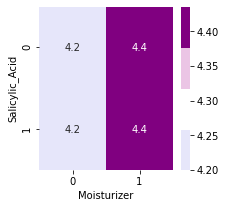

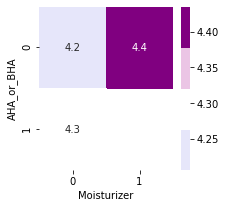

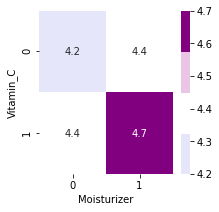

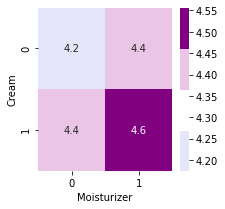

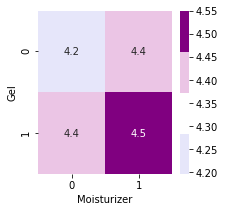

In [28]:
# Let us see factors determining ratings
rating_analysis=['Sun_Protection', 'Retinol', 'Hyaluronic_Acid',
       'Niacinamide', 'Salicylic_Acid','AHA_or_BHA',
       'Vitamin_C','Cream', 'Gel']
for col in rating_analysis: 
    plt.figure(figsize=(3,3))
    data=skincare_cleandata.pivot_table(columns='Moisturizer',index=col,values='Ratings',aggfunc=np.mean)
    sns.heatmap(data,annot=True,cmap=['lavender','white','#EBC5E5','purple'])
    plt.show()

* Moisituriser with vitamin C, retinol and Sun protection are generally highly rated.
* Moisituriser with Niacinamide are low rated .

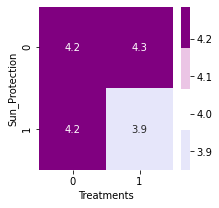

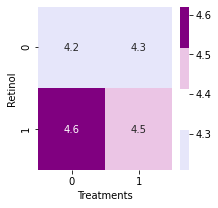

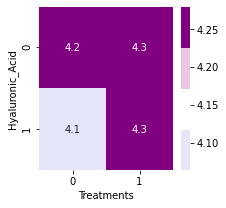

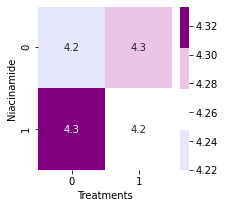

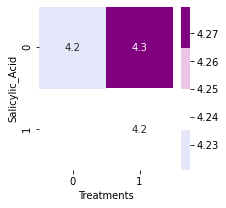

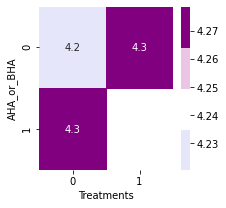

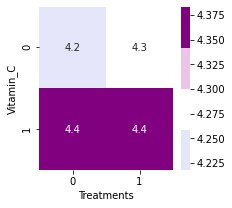

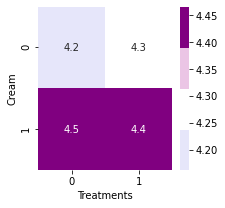

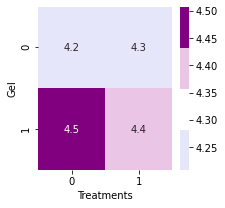

In [29]:
for col in ['Sun_Protection', 'Retinol', 'Hyaluronic_Acid',
       'Niacinamide', 'Salicylic_Acid','AHA_or_BHA',
       'Vitamin_C','Cream', 'Gel']:
    plt.figure(figsize=(3,3))
    data=skincare_cleandata.pivot_table(columns='Treatments',index=col,values='Ratings',aggfunc=np.mean)
    sns.heatmap(data,annot=True,cmap=['lavender','white','#EBC5E5','purple'])
    plt.show()

* Treatments with Hylaronic acid, vitamin C and salicylic acid are highly rated
* Treatments with Niacinamide are low rated.

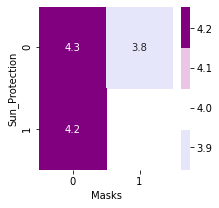

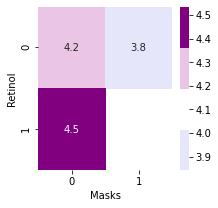

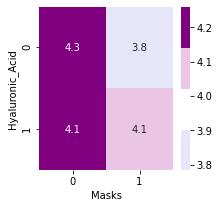

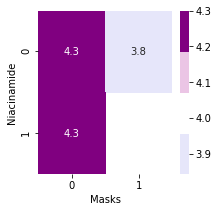

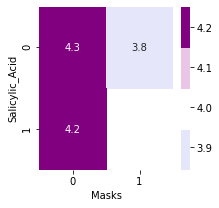

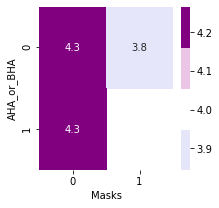

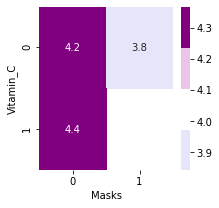

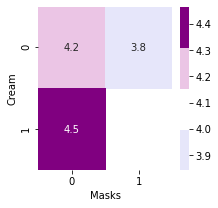

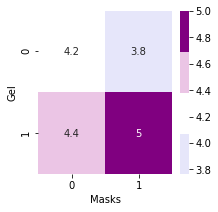

In [30]:
for col in ['Sun_Protection', 'Retinol', 'Hyaluronic_Acid',
       'Niacinamide', 'Salicylic_Acid','AHA_or_BHA',
       'Vitamin_C','Cream', 'Gel']:
    plt.figure(figsize=(3,3))
    data=skincare_cleandata.pivot_table(columns='Masks',index=col,values='Ratings',aggfunc=np.mean)
    sns.heatmap(data,annot=True,cmap=['lavender','white','#EBC5E5','purple'])
    plt.show()

* Masks witg Hylaronic acid and are gelbased are highly rated.
* while masks with contain active ingredient are absent in our data.

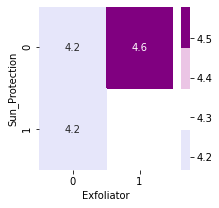

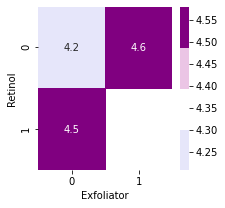

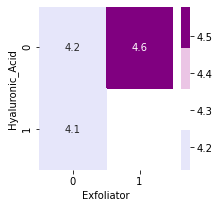

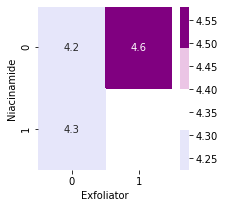

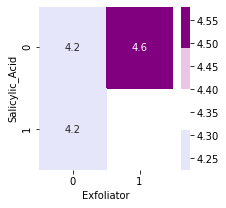

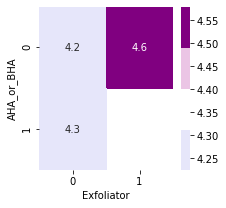

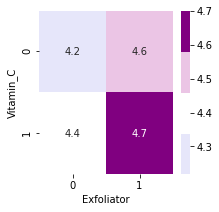

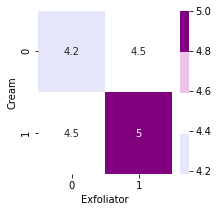

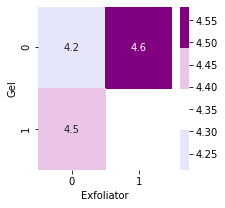

In [31]:
for col in ['Sun_Protection', 'Retinol', 'Hyaluronic_Acid',
       'Niacinamide', 'Salicylic_Acid','AHA_or_BHA',
       'Vitamin_C','Cream', 'Gel']:
    plt.figure(figsize=(3,3))
    data=skincare_cleandata.pivot_table(columns='Exfoliator',index=col,values='Ratings',aggfunc=np.mean)
    sns.heatmap(data,annot=True,cmap=['lavender','white','#EBC5E5','purple'])
    plt.show()

* Exfoliators with Vitamin C and cream based are high rated.
* No enough data for exfoliators with active ingredients.


## Preparing data for model building.

Since the recommendation engine is content based and we are going to use cosine similarity to recommend products, we need the data in form of matrix.
* Prepare a matrix called product_details_matrix that contains only numerical / transformed categorical columns
* exclude index, product brand, product description from matrix

In [32]:
# Check the columns
skincare_cleandata.columns

Index(['Product Brand', 'Product Description', 'Ratings', 'Skin Concern',
       'Review_Count', 'minimum_price_dollars', 'maximum_price_dollars',
       'size_available', 'Moisturizer', 'Cleanser', 'Exfoliator', 'Treatments',
       'Masks', 'Eye_Care', 'Sun_Protection', 'Retinol', 'Hyaluronic_Acid',
       'Niacinamide', 'Salicylic_Acid', 'Toner', 'Cream', 'Gel', 'AHA_or_BHA',
       'Vitamin_C', 'brighten', 'aging', 'dark_spots', 'dryness', 'dullness'],
      dtype='object')

In [33]:
# create a matrix with required data
product_details_matrix=skincare_cleandata[['Ratings','Review_Count', 'minimum_price_dollars', 'maximum_price_dollars',
       'size_available', 'Moisturizer', 'Cleanser', 'Exfoliator', 'Treatments',
       'Masks', 'Eye_Care', 'Sun_Protection', 'Retinol', 'Hyaluronic_Acid',
       'Niacinamide', 'Salicylic_Acid', 'Toner', 'Cream', 'Gel', 'AHA_or_BHA',
       'Vitamin_C', 'brighten', 'aging', 'dark_spots', 'dryness', 'dullness']]


In [34]:
product_details_matrix

,Ratings,Review_Count,minimum_price_dollars,maximum_price_dollars,size_available,Moisturizer,Cleanser,Exfoliator,Treatments,Masks,Eye_Care,Sun_Protection,Retinol,Hyaluronic_Acid,Niacinamide,Salicylic_Acid,Toner,Cream,Gel,AHA_or_BHA,Vitamin_C,brighten,aging,dark_spots,dryness,dullness
0,4.5,4321,49.00,74.00,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,4.6,2120,25.00,79.00,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,4.4,446,48.00,48.00,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0
3,4.6,2487,24.00,82.00,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,4.4,1970,39.00,59.00,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,4.4,272,70.00,70.00,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
6,4.3,765,88.00,88.00,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
7,4.3,1534,6.80,6.80,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
8,4.8,351,44.00,44.00,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
9,4.8,1664,36.00,36.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [35]:
# Shape of the matrix
product_details_matrix.shape

(464, 26)

#### Since the number of components is 26 , we can reduce the domensions into 2 components, if the number of features are high then use
* PCA - for dense data
* TSVD for Sparse data 
* Thus reducing , the noise first and then reducing the dimensions.

In [36]:
# There are 26 columns let us use TSNE to reduce the componenents into 2 domponents 


tsne = TSNE(n_components = 2, n_iter = 1000000, random_state = 6) # reduce 150 features to 2 using t-SNE with exact method
tsne_features = tsne.fit_transform(product_details_matrix)

skincare_cleandata['X'] = tsne_features[:, 0]
skincare_cleandata['Y'] = tsne_features[:, 1]


In [37]:
# Concatenating the full product details so that finally when the recommendation works , the products are clear
skincare_cleandata['Full_Product']=skincare_cleandata['Product Brand']+'-'+skincare_cleandata['Product Description']
skincare_cleandata.head(5)

,Product Brand,Product Description,Ratings,Skin Concern,Review_Count,minimum_price_dollars,maximum_price_dollars,size_available,Moisturizer,Cleanser,Exfoliator,Treatments,Masks,Eye_Care,Sun_Protection,Retinol,Hyaluronic_Acid,Niacinamide,Salicylic_Acid,Toner,Cream,Gel,AHA_or_BHA,Vitamin_C,brighten,aging,dark_spots,dryness,dullness,X,Y,Full_Product
0,IT COSMETICS,Confidence In A Cream Anti-Aging Moisturizer,4.5,dryness,4321,49.0,74.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,-19.641281,40.997944,IT COSMETICS-Confidence In A Cream Anti-Aging Moisturizer
1,CLINIQUE,Moisture Surge 100H Auto-Replenishing Hydrator Moisturizer,4.6,dryness,2120,25.0,79.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-13.591310,36.508369,CLINIQUE-Moisture Surge 100H Auto-Replenishing Hydrator Moisturizer
2,TULA,Brightening Treatment Drops Triple Vitamin C Serum,4.4,dryness,446,48.0,48.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,4.098391,4.641786,TULA-Brightening Treatment Drops Triple Vitamin C Serum
3,TULA,24-7 Moisture Hydrating Day & Night Cream,4.6,dryness,2487,24.0,82.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,-14.717019,38.013695,TULA-24-7 Moisture Hydrating Day & Night Cream
4,PEACH & LILY,Glass Skin Refining Serum,4.4,dryness,1970,39.0,59.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-12.518471,36.434048,PEACH & LILY-Glass Skin Refining Serum


In [38]:
source = ColumnDataSource(skincare_cleandata)

In [39]:
# unique concerns into list
concerns=[]
for col in skincare_cleandata['Skin Concern'].unique():
    concerns.append(col)
concerns

['dryness', 'dullness', 'aging', 'acne+blemish', 'dark_spots']

In [40]:
# Plot the similarities that are condensed into 2 columns X and Y that has been obtained using TSNE to view similar data points.

plot = figure(title = "Mapped Similarities", width = 800, height = 600)
plot.xaxis.axis_label = "t-SNE 1"
plot.yaxis.axis_label = 't-SNE 2'
plot.circle(x = 'X', y = 'Y', source = source, fill_alpha=0.7, size=10,
           color = '#c0a5e3', alpha = 1)
plot.background_fill_color = "#E9E9E9"
plot.background_fill_alpha = 0.3

hover = HoverTool(tooltips=[('Product', '@Full_Product'), ('Min Price', '@minimum_price_dollars'),('Max Price', '@maximum_price_dollars')])
plot.add_tools(hover)

def type_updater(Skin_Concern = concerns[1]):
    new_data = {'X' : skincare_cleandata[skincare_cleandata['Skin Concern'] == Skin_Concern]['X'],
                'Y' : skincare_cleandata[skincare_cleandata['Skin Concern'] == Skin_Concern]['Y'],
                'product_name' : skincare_cleandata[skincare_cleandata['Skin Concern'] == Skin_Concern]['Full_Product'],
                'Min price' : skincare_cleandata[skincare_cleandata['Skin Concern'] == Skin_Concern]['minimum_price_dollars	'],
               ' Max price' : skincare_cleandata[skincare_cleandata['Skin Concern'] == Skin_Concern]['maximum_price_dollars	']}
    source.data = new_data

show(plot, notebook_handle = False)

## Building a Skin care recommender using content based filtering and recommending similar products

Steps used are ,
* Get the input from user - which is a skin concern.
* Take the Top 1 row that addresses this skin concern (by filtering skin concern= user input) and sorting it based on ratings in descending
* Calculate similarity between this data point(vector) and rest of the data points(vectors) in our datasets using cosine similarity.
 
 
 **cosine similarity (CS) = (A . B) / (||A|| ||B||)** where A and B are two vectors.
 
* when similarity is closer to 1 they are similar .. that two vectors lie in same plane and closer to o , they are not similar.
* Show top 5 product details with highest cosine similairty



In [41]:
# Defining the Recommender system and recommending products based on the skin concerns
def skincare_recommender(concern):
    cs_list = []
    brands = []
    output = []
    binary_list = []
    idx=skincare_cleandata[skincare_cleandata['Skin Concern'] == lower(concern)].sort_values('Ratings', ascending=False).head(1).index.item()
    for i in product_details_matrix.iloc[idx][:]:
        binary_list.append(i)
    point1 = np.array(binary_list).reshape(1, -1)
    point1 = [val for sublist in point1 for val in sublist]
    for j in range(skincare_cleandata.index[0], skincare_cleandata.index[0] + len(skincare_cleandata)):
        binary_list2=[]
        for k in product_details_matrix.iloc[j][:]:
            binary_list2.append(k)
        point2=np.array(binary_list2).reshape(1,-1)
        point2 = [val for sublist in point2 for val in sublist]
        dot_product=np.dot(point1,point2)
        norm_1 = np.linalg.norm(point1)
        norm_2 = np.linalg.norm(point2)
        cos_sim = dot_product / (norm_1 * norm_2)
        cs_list.append(cos_sim)
    data_by_concern=skincare_cleandata
    data_by_concern['cos_sim'] = cs_list
    data_by_concern = data_by_concern.sort_values('cos_sim', ascending=False)
    top10_recommend=data_by_concern[['Full_Product', 'cos_sim','minimum_price_dollars']].head(10)
    print('\033[1m', 'Recommending products for the skin concern', concern,':', '\033[0m')
    return top10_recommend

    

In [44]:
# Endpoint get the user input
print ("Enter the skin concern from the displayed list ")
print (" 1.Dullness 2.Acne+Blemish 3.Dryness 4.Aging 5.dark_spots")
user_concern=input()
print(user_concern)
skincare_recommender(user_concern.lower())

Enter the skin concern from the displayed list 
 1.Dullness 2.Acne+Blemish 3.Dryness 4.Aging 5.dark_spots
Dullness
Dullness
 Recommending products for the skin concern dullness : 


,Full_Product,cos_sim,minimum_price_dollars
183,ELEMIS-Superfood Fruit Vinegar Liquid Glow,1.000000,36.00
338,KINSHIP-Kinskin Oat Ceramide Relief Oil,0.999795,35.00
145,INDIE LEE-Brightening Cream,0.999562,42.00
222,MICHAEL TODD BEAUTY-Microsmooth Sonic Microdermabrasion Tips,0.999481,39.00
148,KOPARI BEAUTY-California Glow Enzyme Face Scrub,0.999398,28.00
179,FRESH-Travel Size Sugar Face Polish,0.999243,25.00
108,CLINIQUE-More than Moisture: Moisture Surge Set,0.999162,49.50
221,CONAIR-True Glow Rechargeable Microdermabrasion Beauty Tool,0.999075,39.99
157,KEYS SOULCARE-Obsidian Facial Roller,0.998804,25.00
261,LA ROCHE-POSAY-Effaclar Pore-Refining Anti-Aging Serum,0.998772,44.99


#### Conclusion and Future enhancement of the application:

* Thus we have built a skincare recommender for customers who specifically shop at ULTA BEAUTY.
* This recommeder suggestd product based on skin concern and shows top 10 products for that particular concern, from which customer may make the choice.

### Future Enhancement of the application.

* Details user reviews can be collected , from which we can do sentiment analysis
* collect more detailed ingredient list of each product that are in our data.
* Can collect higher number of records, so that our machine learning model is generalised.
* Build user profile that has shopped various product, thus giving based on collabrative filtering. That is content as well user based.
* Deploy this model into production.

        